# Import pacakges

In [1]:
from WEB import *

In [2]:
import numpy as np

# Real data

### Initial value

In [3]:
# PROTEIN = "6z6u"
# EM_MAP = "11103"
PROTEIN = "7d1t"
EM_MAP = "30547"

BASE_NUM_POINTS = 8
MAX_POINTS = 8
MAX_ITER = 500
ALPHA = 0.2
GAMMA = 0.5
TOL = 1e-20

root_map=f'./dataset/emd_{EM_MAP}.map'
root_pdb=f'./dataset/{PROTEIN}.pdb'

### read data

In [4]:
web = WEB(start_radius=0, max_radius=1, gap=0.1)
data = web.read_data(
    root_map=root_map, 
    root_pdb=root_pdb,
    atoms=["CA"],
    base_num_points=BASE_NUM_POINTS, 
    max_points=MAX_POINTS, 
    )

100%|██████████| 5300/5300 [00:02<00:00, 2516.66it/s]


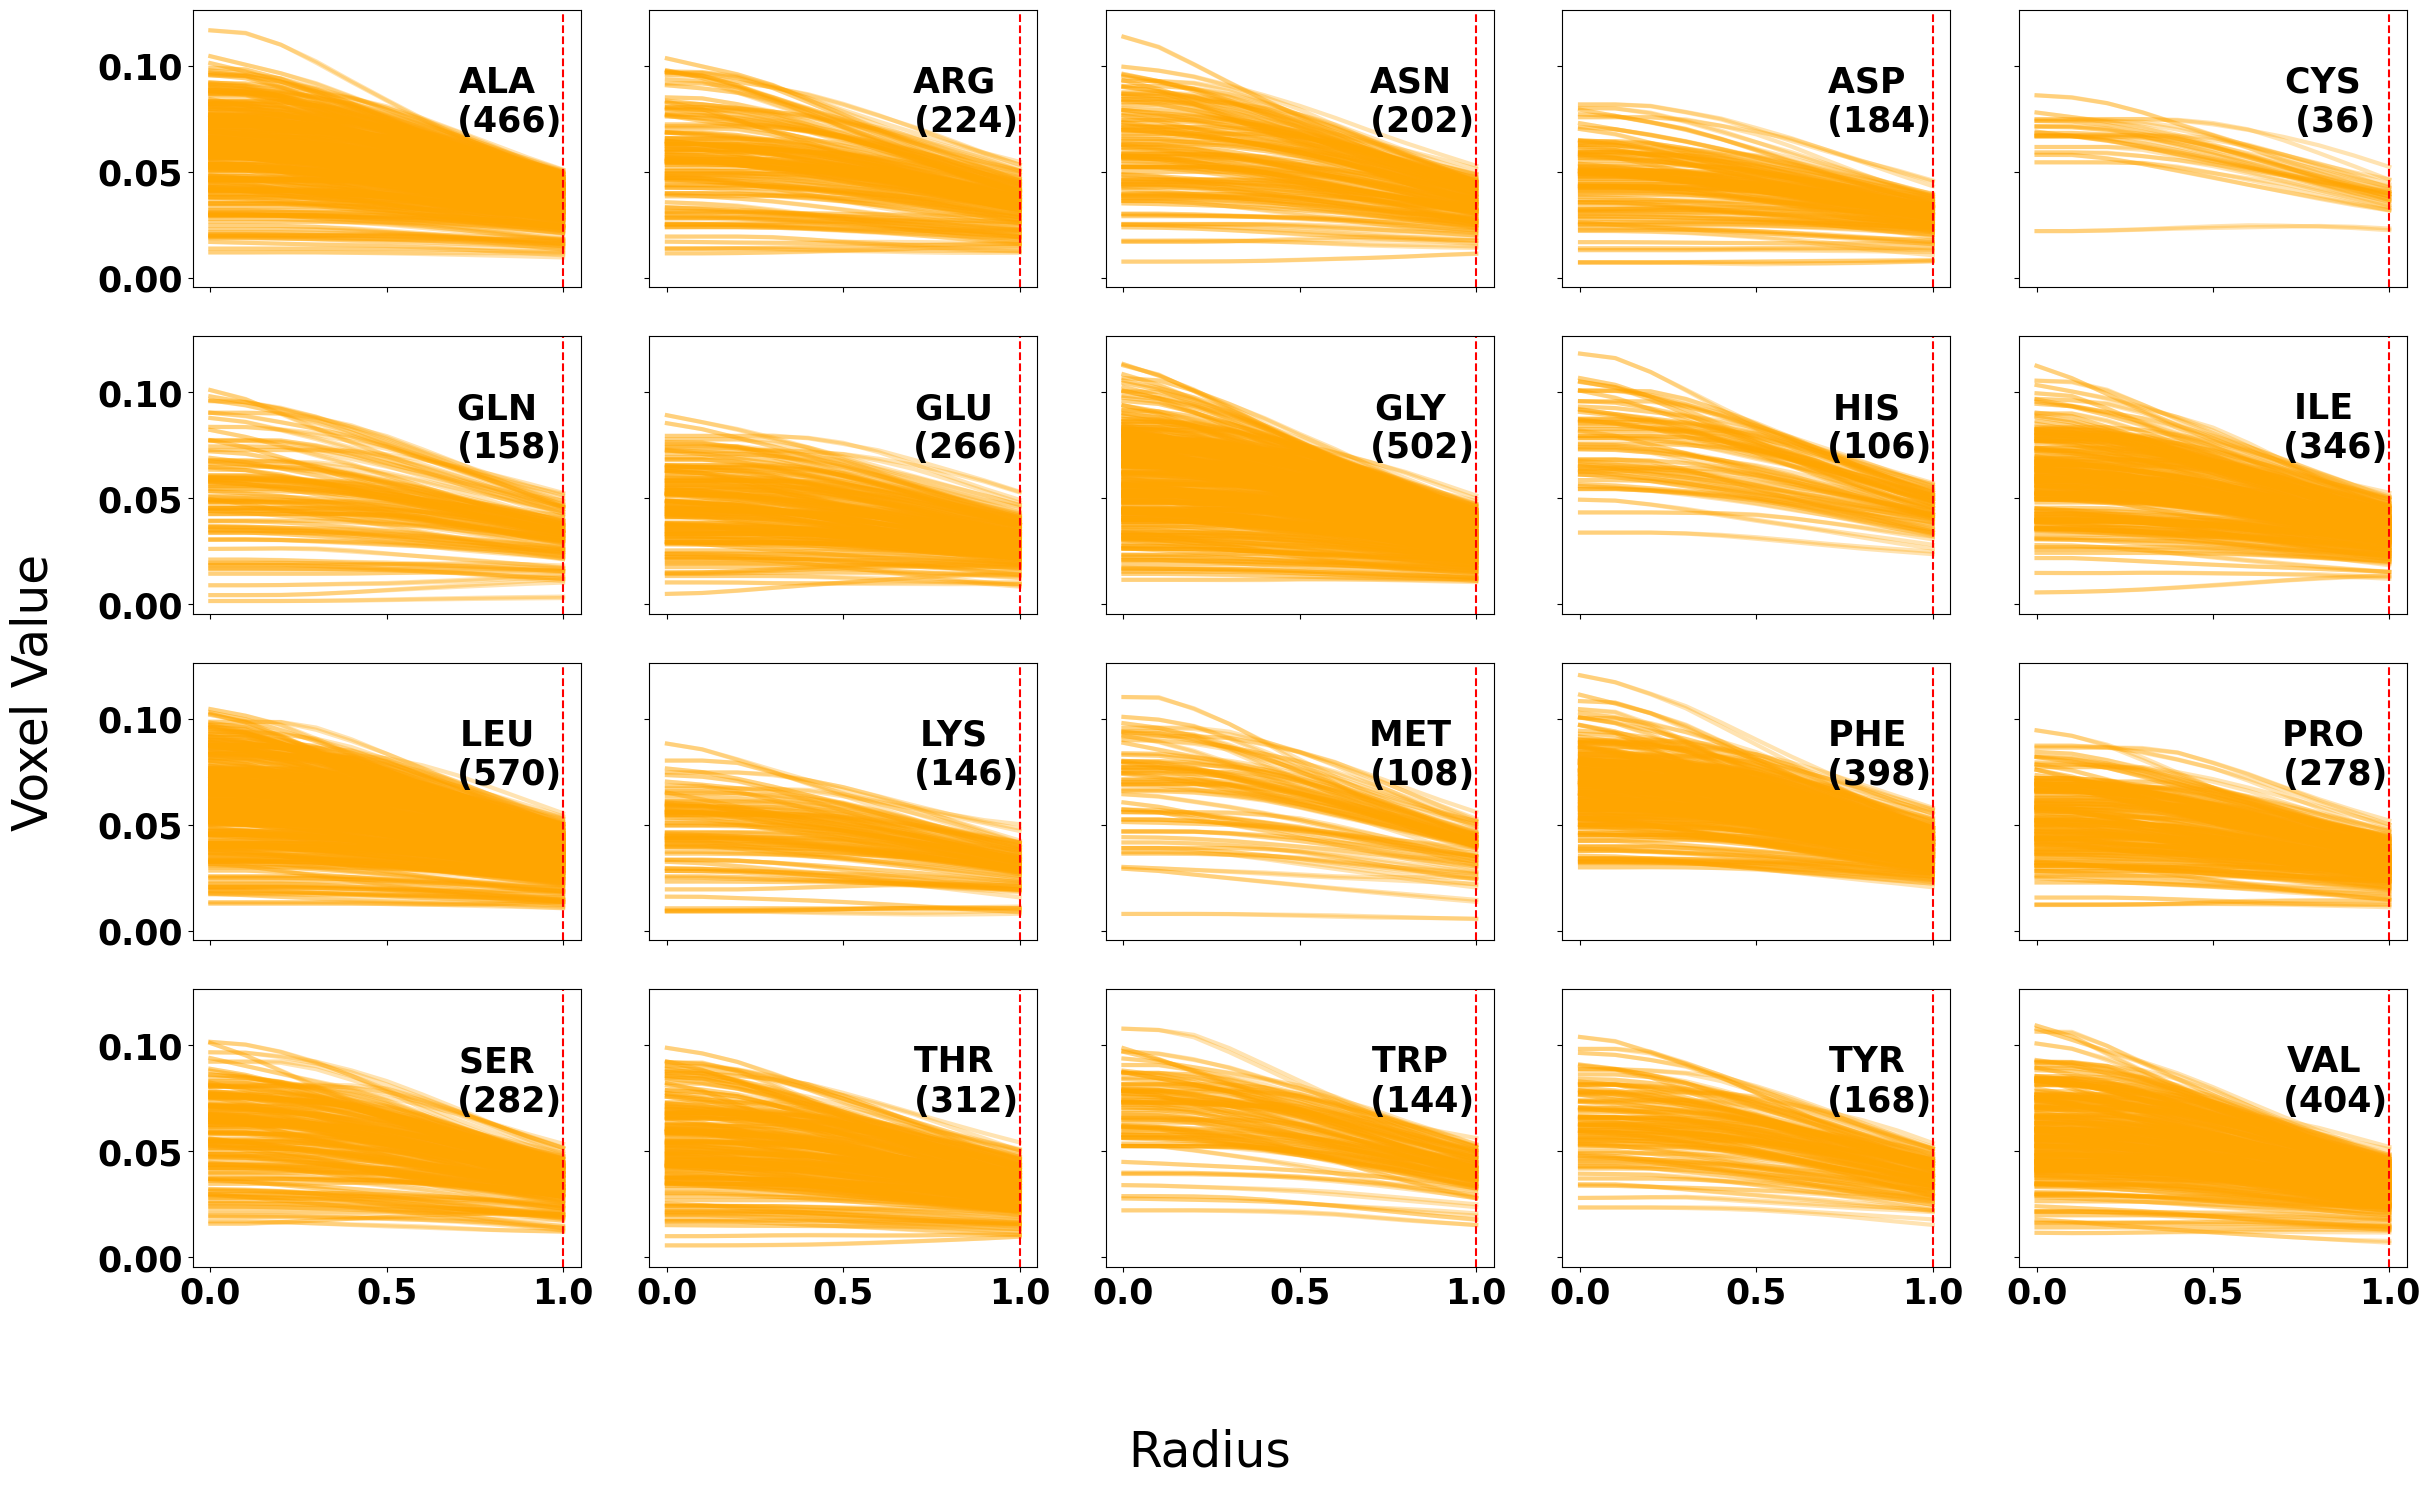

In [5]:
web.densities_plot(f"./figures/densities_plot_{PROTEIN}_{EM_MAP}")

### Fit our model

In [87]:
_ = web.paramters_initial()
betas_WEB = web.WEB_iter_test2(max_iter=MAX_ITER, alpha=ALPHA, gamma=ALPHA, tol=TOL)

INFO:root:ALA MDPDE finished in iteration: 176
INFO:root:ALA WEB finished in iteration: 20
INFO:root:===================================
INFO:root:ARG MDPDE finished in iteration: 199
INFO:root:ARG WEB finished in iteration: 21
INFO:root:===================================
INFO:root:ASN MDPDE finished in iteration: 129
INFO:root:ASN WEB finished in iteration: 17
INFO:root:===================================
INFO:root:ASP MDPDE finished in iteration: 117
INFO:root:ASP WEB finished in iteration: 23
INFO:root:===================================
INFO:root:CYS MDPDE finished in iteration: 17
INFO:root:CYS WEB finished in iteration: 17
INFO:root:===================================
INFO:root:GLN MDPDE finished in iteration: 80
INFO:root:GLN WEB finished in iteration: 20
INFO:root:===================================
INFO:root:GLU MDPDE finished in iteration: 32
INFO:root:GLU WEB finished in iteration: 17
INFO:root:===================================
INFO:root:GLY MDPDE finished in iteration: 2

In [7]:
def func(theta, X_tilde, y_tilde, alpha):
    beta, sigma = theta[:2], theta[2]
    resedual = y_tilde - np.dot(X_tilde, beta)
    weight = np.exp(-alpha * resedual ** 2 / (2 * sigma))
    ans1 = np.sum(X_tilde * (resedual * weight).reshape(-1, 1), axis=0)
    ans2 = np.sum((1 - resedual ** 2 / sigma) * weight, axis=0) - alpha / (1 + alpha) ** (3 / 2)
    return np.append(ans1, ans2)

In [8]:
name = "GLY"
j = 11
X_tilde, y_tilde = web.Xs_tilde[name][j], web.data_log[name][j]
beta, sigma = web.betas_MDPDE[name][j], web.sigmas_MDPDE[name][j]
alpha = 0.2
func(np.append(beta, sigma), X_tilde, y_tilde, alpha)

array([-4.53781580e-04,  1.85164500e-04,  1.32405577e+01])

In [9]:
# q_score = q_scores["ALA"]
# density = web.densities_data["ALA"]
# plt.plot(density[np.where(q_score == np.max(q_score))].reshape(-1))

In [10]:
x = np.unique(web.distances_to_center["ALA"][0])
x = np.repeat(x, BASE_NUM_POINTS)

In [15]:
all_data = None
for data in web.data.values():
    if all_data is None:
        all_data = data
    else:
        all_data = np.concatenate((all_data, data), axis=0)
avg_M = all_data.mean(axis=0)
sigma_M = all_data.std(axis=0)
# A = avg_M + 10 * sigma_M
# B = avg_M - sigma_M
A, B = 1, 1
sigma = 0.6
y = (A * np.exp(-1 / (2 * sigma**2) * x**2) + B).tolist()
q_score_data = {name: np.array(y * len(beta)).reshape(-1, len(y)) for name, beta in web.betas_MDPDE.items()}

In [54]:
sigmas_WEB = {name: value[0] for name, value in estimators_atom["CA"].items()}
sigmas_WEB

{'ALA': 0.9113019590225397,
 'ARG': 0.9661613784317858,
 'ASN': 0.8853481055273534,
 'ASP': 0.9845501177001964,
 'CYS': 0.7804427271053334,
 'GLN': 0.9715383842159703,
 'GLU': 1.015708675128481,
 'GLY': 0.7079108311199344,
 'HIS': 0.8886730769490149,
 'ILE': 0.8817764448180092,
 'LEU': 0.8895709800546954,
 'LYS': 1.0647309661405457,
 'MET': 0.8380642398125316,
 'PHE': 0.8676483749565774,
 'PRO': 0.9370385721189308,
 'SER': 0.9087712085395068,
 'THR': 0.9324515670529671,
 'TRP': 0.8957209649894875,
 'TYR': 0.9090917867580662,
 'VAL': 0.8911623576195921}

In [58]:
data_estimated_WEB = {name: None for name in sigmas_WEB}
for name, sigma in sigmas_WEB.items():
    y = (A * np.exp(-1 / (2 * sigma**2) * x**2) + B).tolist()
    data_estimated_WEB[name] = np.array(y * len(web.betas_MDPDE[name])).reshape(-1, len(y))

In [73]:
q_scores = caculate_similarity(web.data, q_score_data)
q_scores_WEB = caculate_similarity(web.data, data_estimated_WEB)

In [86]:
font = {'weight' : 'bold', 'size': 10}
matplotlib.rc('font', **font)
for name, q_score, q_score_WEB in zip(q_scores.keys(), q_scores.values(), q_scores_WEB.values()):
    q_score = np.array(q_score)
    q_score_WEB = np.array(q_score_WEB)
    print(name, round(sum(q_score > q_score_WEB) / len(q_score), 4))
    # plt.scatter(q_score[q_score > q_score_WEB], q_score_WEB[q_score > q_score_WEB], c="red")
    # plt.scatter(q_score[q_score < q_score_WEB], q_score_WEB[q_score < q_score_WEB], c="green")
    # plt.plot(np.linspace(-1, 1, 50), np.linspace(-1, 1, 50), color="black")
    # plt.xlim(-1, 1)
    # plt.ylim(-1, 1)
    # plt.title(name)
    # plt.show()

ALA 0.3648
ARG 0.4152
ASN 0.4109
ASP 0.3696
CYS 0.3056
GLN 0.3481
GLU 0.3947
GLY 0.3466
HIS 0.4623
ILE 0.448
LEU 0.407
LYS 0.3699
MET 0.3889
PHE 0.3744
PRO 0.4388
SER 0.383
THR 0.4744
TRP 0.375
TYR 0.3155
VAL 0.4876


In [28]:
X_tilde = web.Xs_tilde["ALA"][0]
data_estimated_WEB = {name: None for name in web.residue_order}
for name, beta in web.betas_WEB.items():
    data_estimated_WEB[name] = np.exp(beta @ X_tilde.T)

In [32]:
def solve(beta):
    beta_0, beta_1 = beta
    tau = 1 / beta_1
    A = np.exp(beta_0 + 3 / 2 * np.log(beta_1))
    return tau, A

In [36]:
estimators_list = list(map(solve, web.mus_mle.values()))
estimators = {name: estimator for name, estimator in zip(web.mus_mle, estimators_list)}
estimators

{'ALA': (0.916366822333933, 0.0674400501777167),
 'ARG': (1.00625413876499, 0.05422224858407111),
 'ASN': (0.8816771466499365, 0.06977903804973244),
 'ASP': (1.0046094234386, 0.04591786217659119),
 'CYS': (0.8249174438218138, 0.09123206456174882),
 'GLN': (1.0093483643272176, 0.05092874836570073),
 'GLU': (1.0117978843405353, 0.04408206806237429),
 'GLY': (0.71760321848611, 0.0953672219525532),
 'HIS': (0.8766655213410974, 0.09129740285807818),
 'ILE': (0.8898142886704492, 0.06908101149767637),
 'LEU': (0.887189042016846, 0.07168841227976826),
 'LYS': (1.0840909004902282, 0.04274365136980832),
 'MET': (0.8301087570410416, 0.08993357270864823),
 'PHE': (0.8640194823833994, 0.08288403118137187),
 'PRO': (0.9316714364308931, 0.05757377338699811),
 'SER': (0.9176534232300112, 0.06548060560336078),
 'THR': (0.9195540920573103, 0.05840296746778903),
 'TRP': (0.8977752339874454, 0.08128592530159216),
 'TYR': (0.9270942405084475, 0.07066217098791772),
 'VAL': (0.9079547646592541, 0.06503294426

In [63]:
q_score_WEB = caculate_similarity(web.data, data_estimated_WEB)

ValueError: shapes (600,) and (88,) not aligned: 600 (dim 0) != 88 (dim 0)

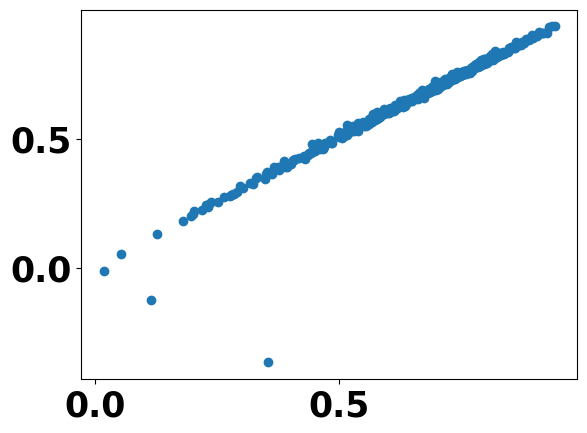

In [31]:
plt.scatter(q_score["ALA"], q_score_WEB["ALA"])

In [25]:
q_score

[0.4066835654993341,
 0.8337879595362189,
 0.8758103245929706,
 0.5273481042554372,
 0.8127624330940209,
 0.6710558048326183,
 0.6842494759326615,
 0.7468963154043914,
 0.6342955827565436,
 0.6697557372414905,
 0.23866358196314943,
 0.8532420330371305,
 0.6898209782776197,
 0.23081832395172838,
 0.5206686078646496,
 0.562341027067347,
 0.8377505821507234,
 0.4311787811122159,
 0.7120971206035687,
 0.44224261852581803,
 0.8375148496052974,
 0.8833554304612781,
 0.811268878297465,
 0.6899129124449696,
 0.8509567977262988,
 0.6341011944691382,
 0.7004623241810954,
 0.51095284653505,
 0.6567856261097087,
 0.7723988305098844,
 0.5394504762497871,
 0.6044367135486538,
 0.8641663297398141,
 0.5764934685237391,
 0.7600621771503734,
 0.7630909194488499,
 0.4384994692598161,
 0.5508612599604528,
 0.9256771739099341,
 0.6621188382381543,
 0.2010227952084864,
 0.6098259064057571,
 0.7932868807504189,
 0.6580605567959682,
 0.7524499063604017,
 0.7493538253547865,
 0.7376723188553059,
 0.72150209636

In [16]:
web.data

{'ALA': array([[0.02057582, 0.02057582, 0.02057582, ..., 0.02260214, 0.01551994,
         0.02345306],
        [0.09219362, 0.09219362, 0.09219362, ..., 0.0456095 , 0.02924931,
         0.0578857 ],
        [0.09559041, 0.09559041, 0.09559041, ..., 0.02490986, 0.05429898,
         0.03496736],
        ...,
        [0.0612628 , 0.0612628 , 0.0612628 , ..., 0.0235509 , 0.0335711 ,
         0.05278281],
        [0.07551166, 0.07551166, 0.07551166, ..., 0.03833041, 0.03988738,
         0.02735151],
        [0.07958486, 0.07958486, 0.07958486, ..., 0.01462437, 0.06559599,
         0.04253166]]),
 'ARG': array([[0.07230856, 0.07230856, 0.07230856, ..., 0.01528559, 0.05149997,
         0.02399733],
        [0.0686202 , 0.0686202 , 0.0686202 , ..., 0.05562294, 0.02343908,
         0.02052772],
        [0.07641526, 0.07641526, 0.07641526, ..., 0.05846192, 0.01591922,
         0.05723612],
        ...,
        [0.06379855, 0.06379855, 0.06379855, ..., 0.03945647, 0.03010192,
         0.04154373]

In [50]:
web.distances_to_center["ALA"][0]

array([0. , 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.2, 0.2, 0.2, 0.2,
       0.2, 0.2, 0.2, 0.2, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.4,
       0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.7, 0.7, 0.7,
       0.7, 0.7, 0.7, 0.7, 0.7, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8,
       0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 1. , 1. , 1. , 1. , 1. ,
       1. , 1. , 1. ])

In [17]:
font = {'weight' : 'bold', 'size': 10}
matplotlib.rc('font', **font)
q_scores = caculate_similarity(web.densities_data, y)
web_q_scores = caculate_similarity(web.densities_data, web.densities_WEB)
for name, q_score, web_q_score, q_scores_beta, web_beta, density_data in zip(q_scores.keys(), q_scores.values(), web_q_scores.values(), q_scores_beta.values(), web.betas_WEB.values(), web.densities_data.values()):
    for i in range(len(q_score)):
        if np.abs(q_score[i] - web_q_score[i]) > 1:
            print(web_beta[i], q_scores_beta[i])
            plt.plot(np.exp(X_tilde @ web_beta[i]), label="WEB", alpha=0.5, linestyle="--")
            plt.plot(np.exp(y), label="Q-score", alpha=0.5, linestyle="--")
            plt.plot(density_data[i], label="data", alpha=0.5)
            plt.legend()
            plt.title(name)
            plt.show()
            break

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

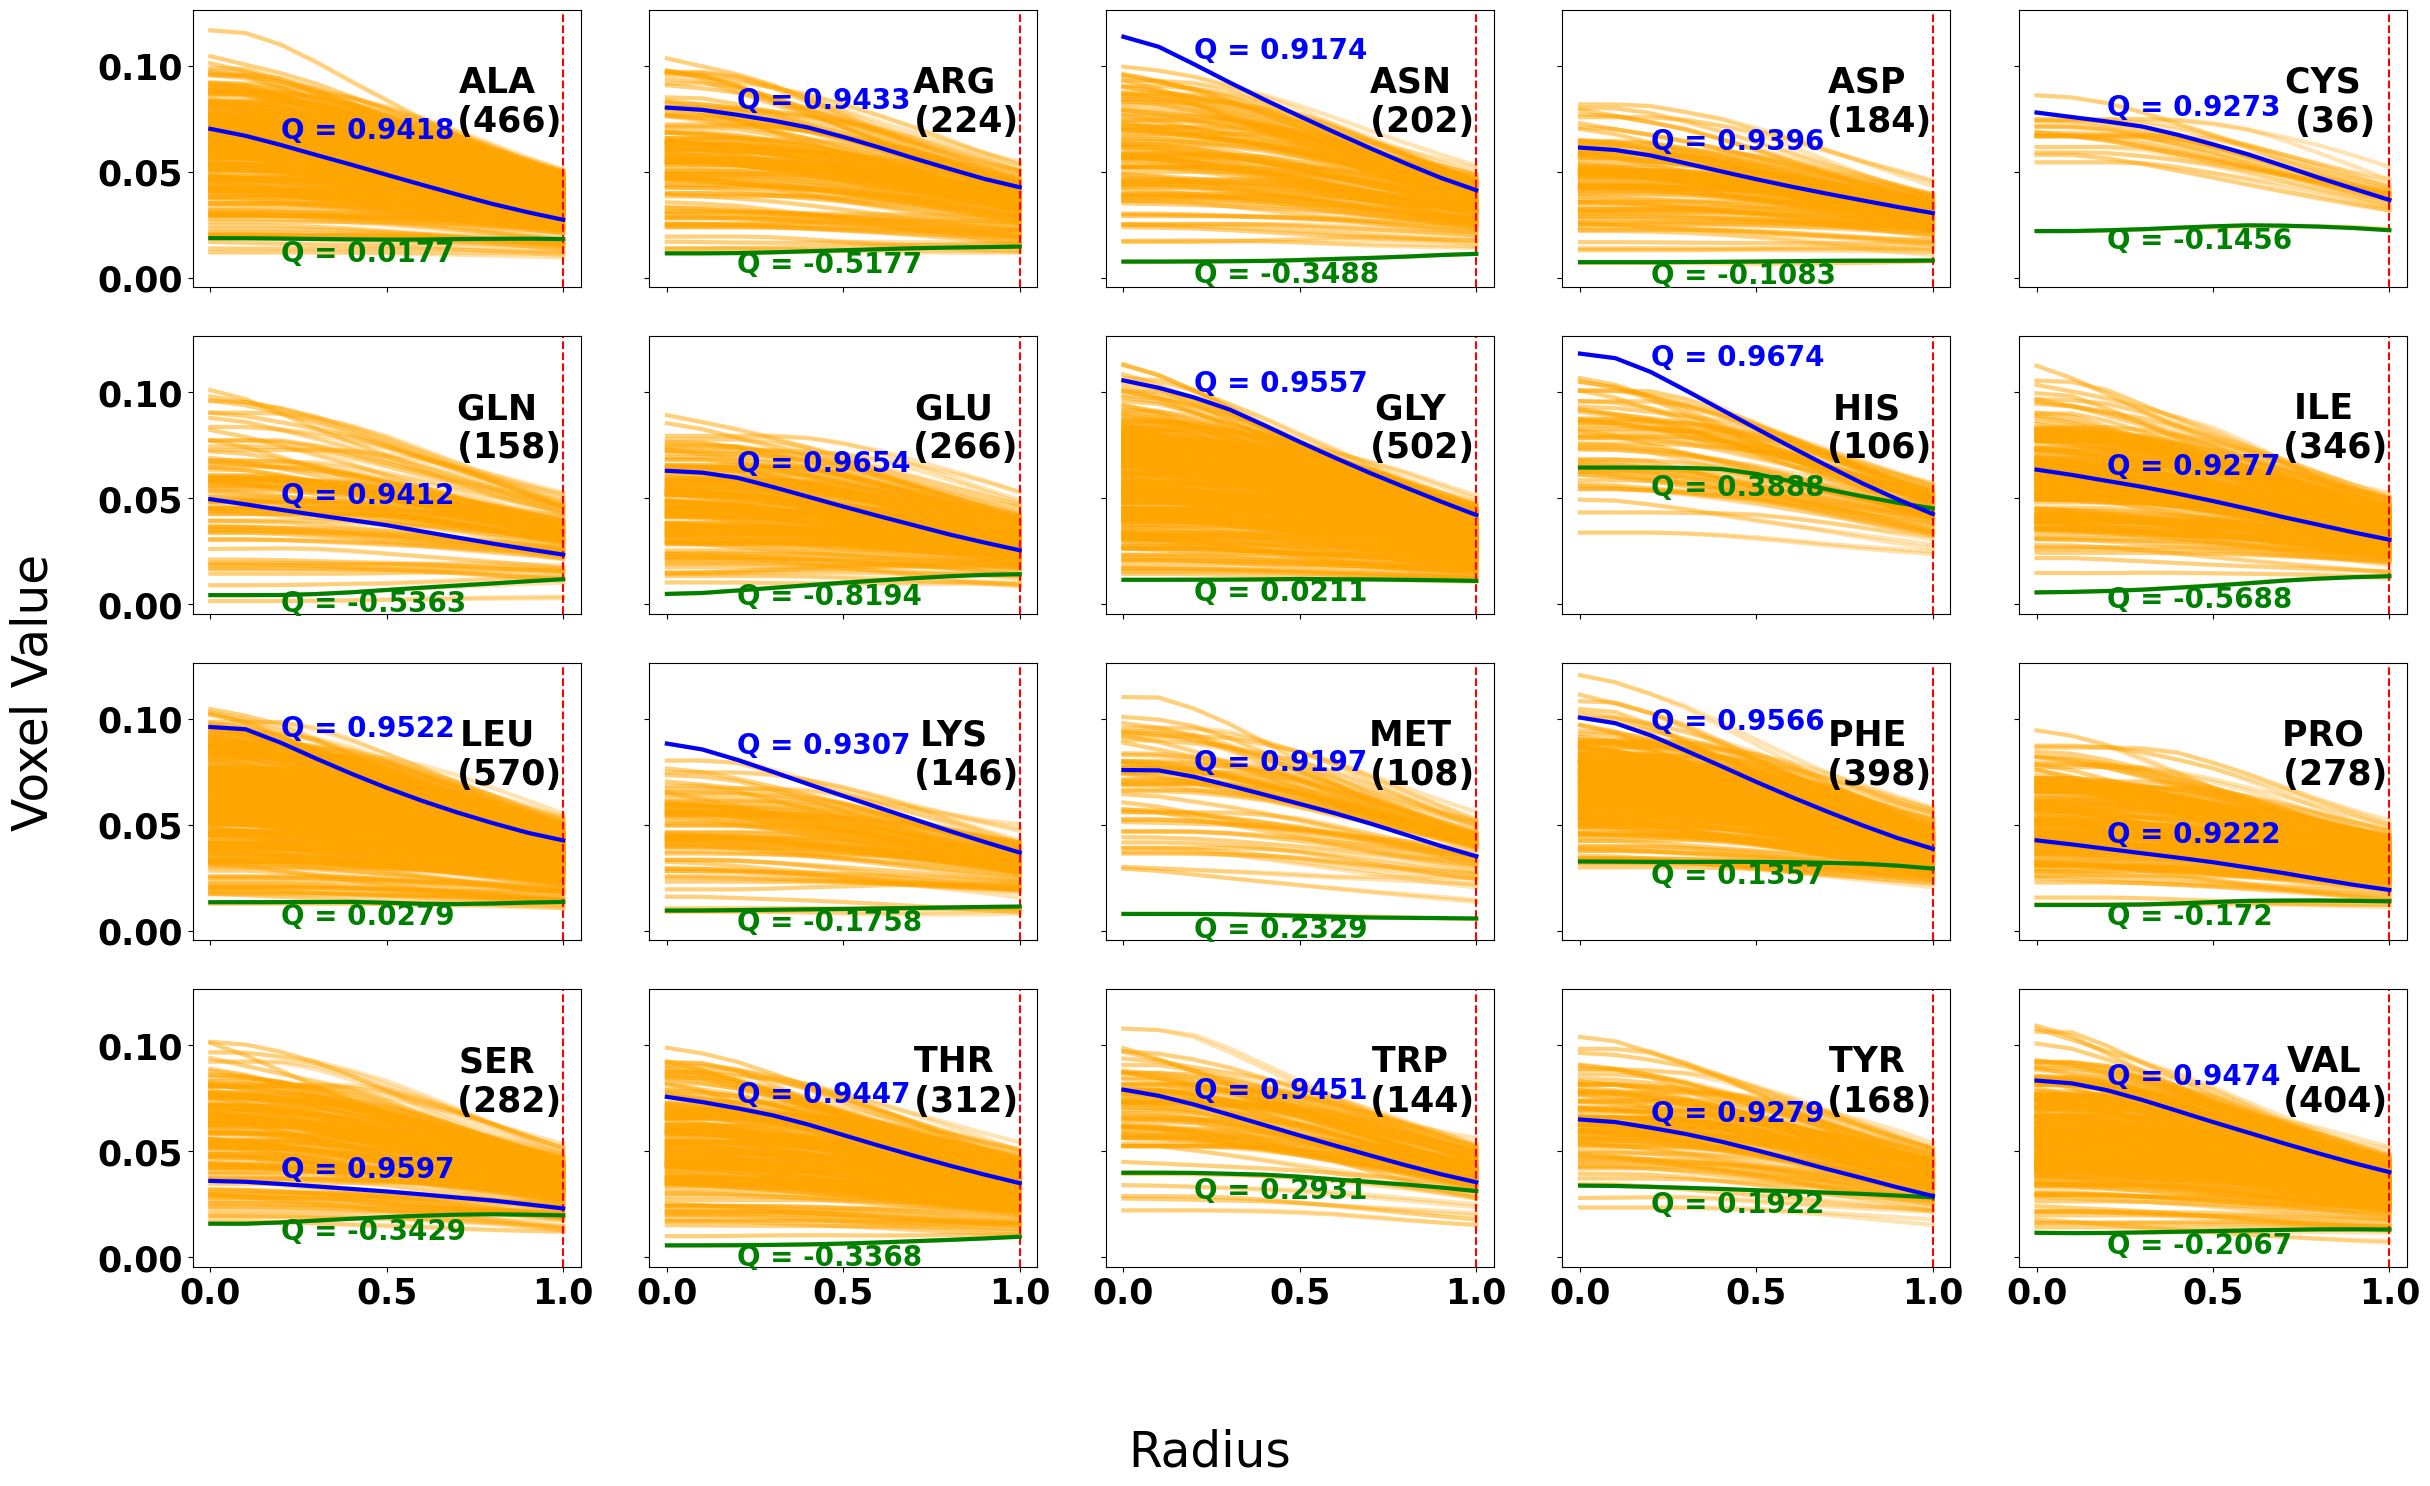

In [88]:
# q_scores = caculate_similarity(web.densities_data, web.densities_WEB)
web.densities_plot(f"./figures/densities_plot_{PROTEIN}_{EM_MAP}", q_scores=q_scores)

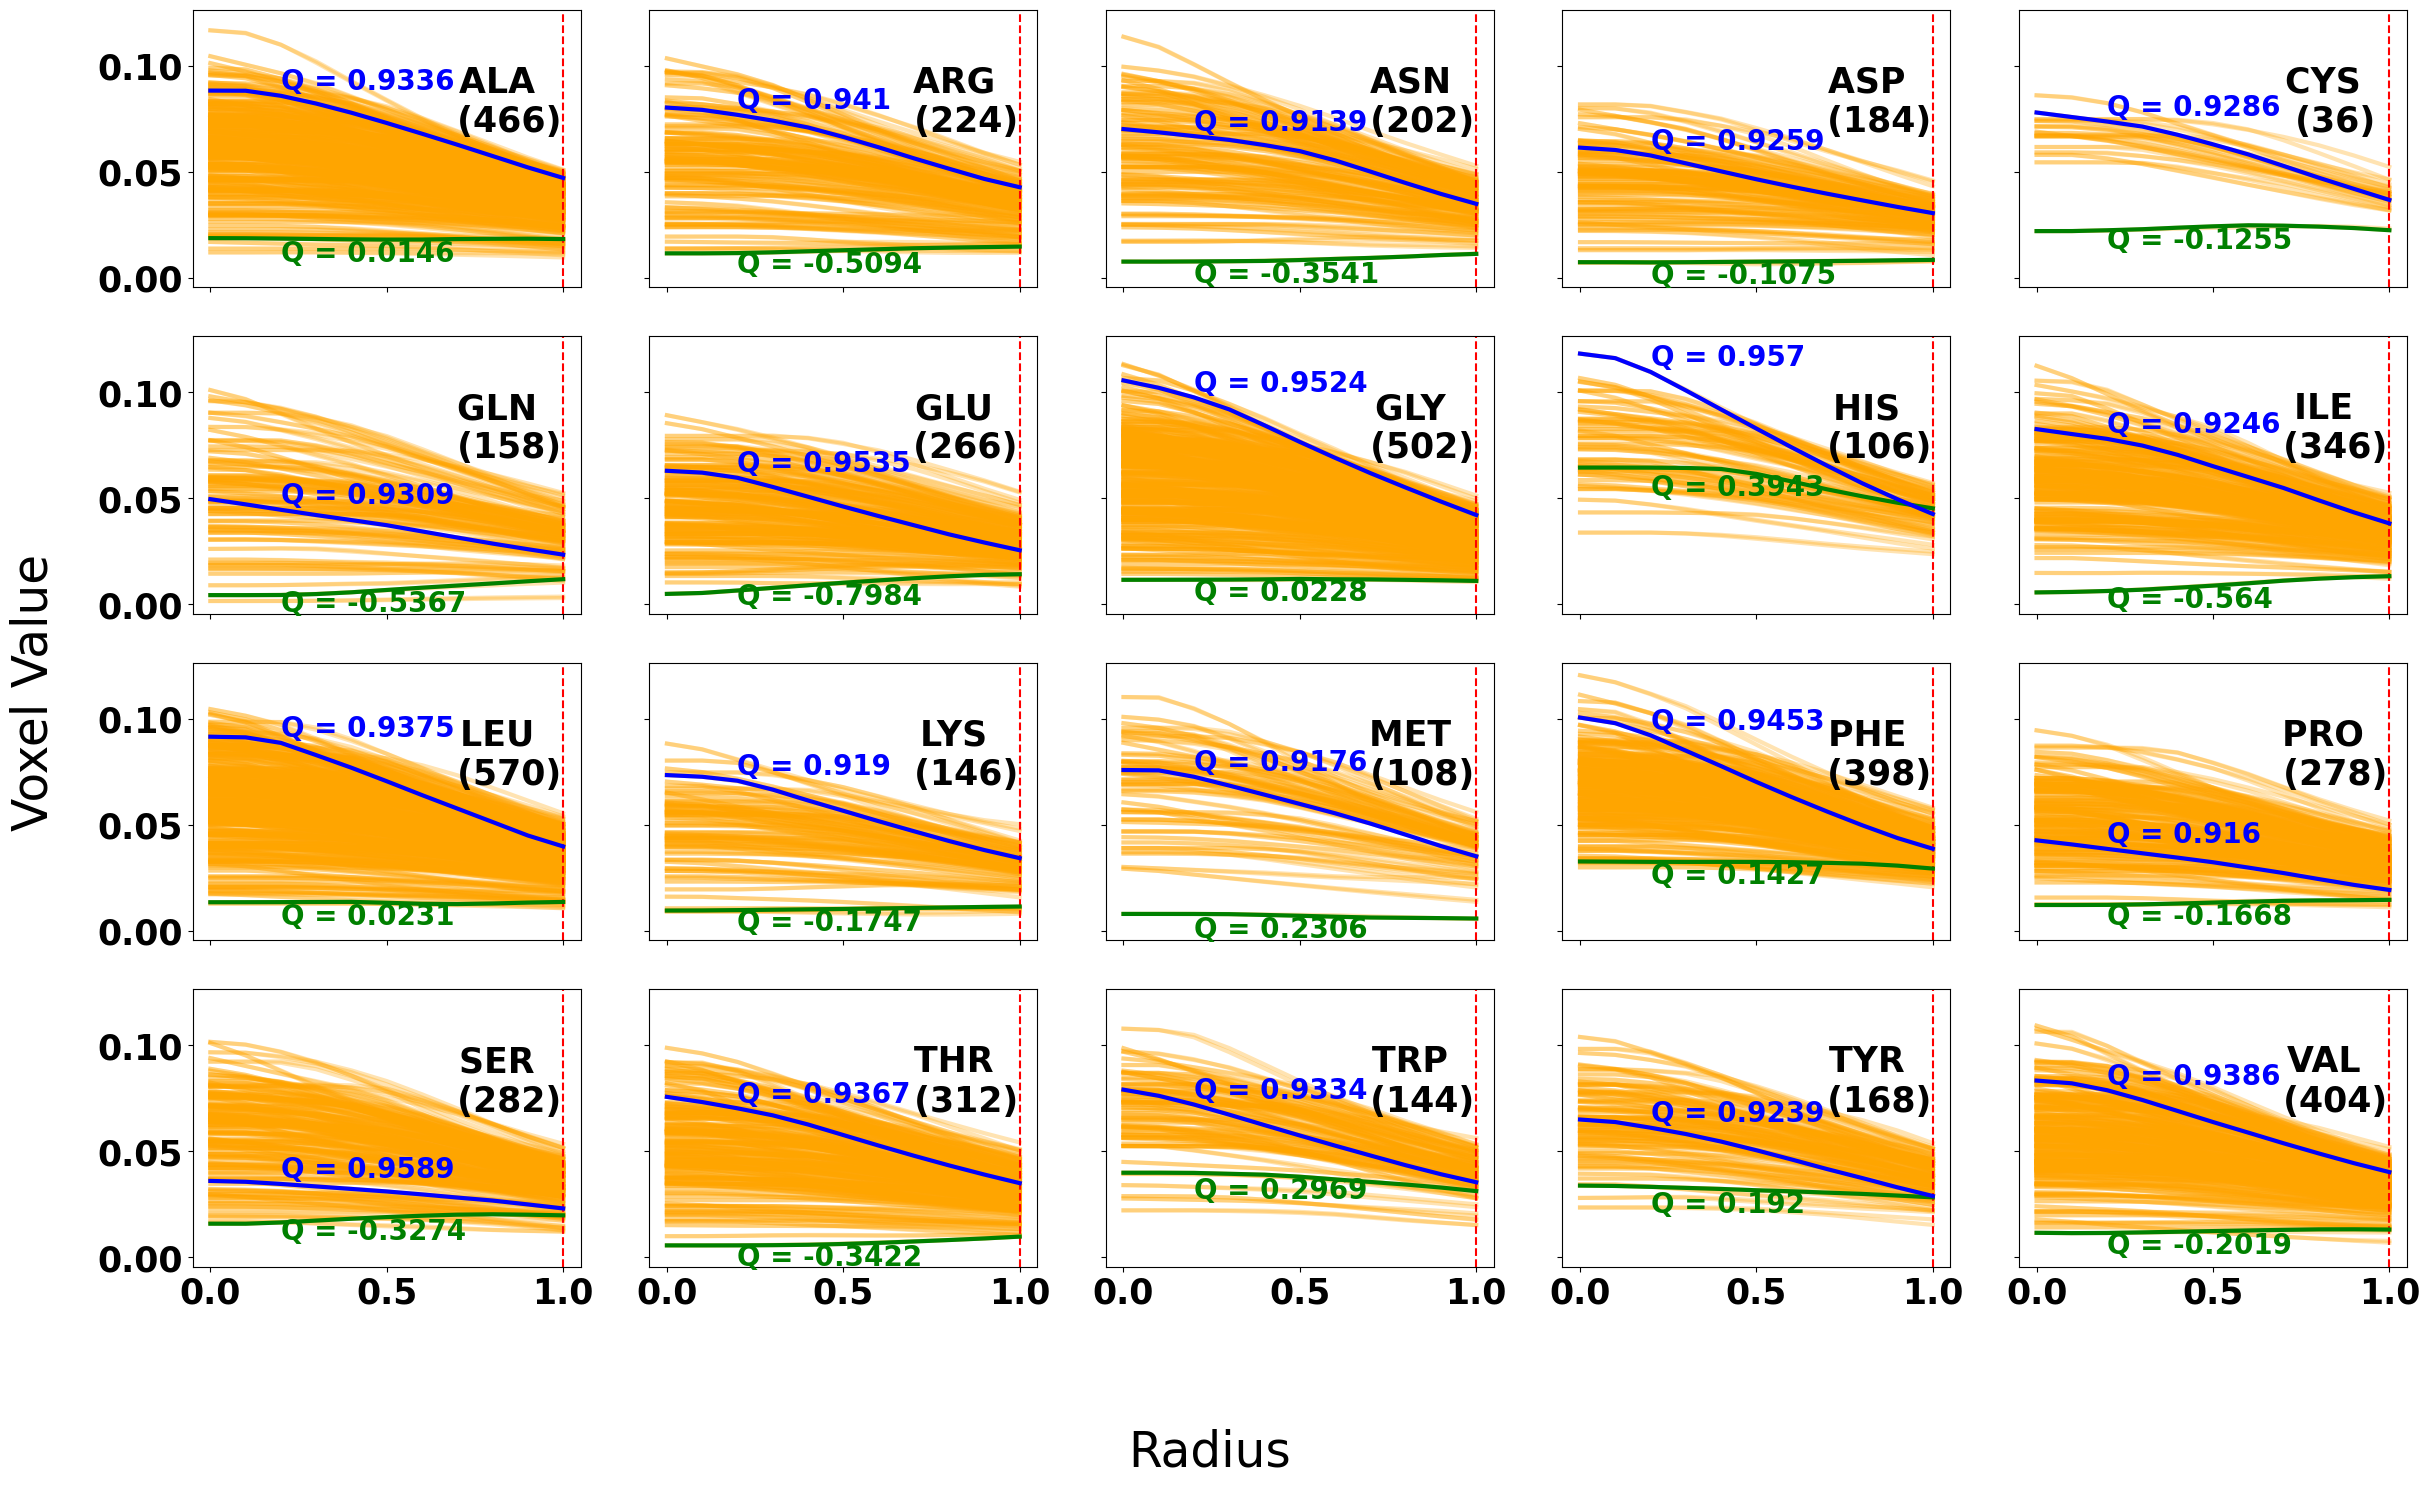

In [89]:
web.densities_plot(f"./figures/densities_plot_{PROTEIN}_{EM_MAP}", q_scores=q_scores_WEB)

### Plot results

<Figure size 640x480 with 0 Axes>

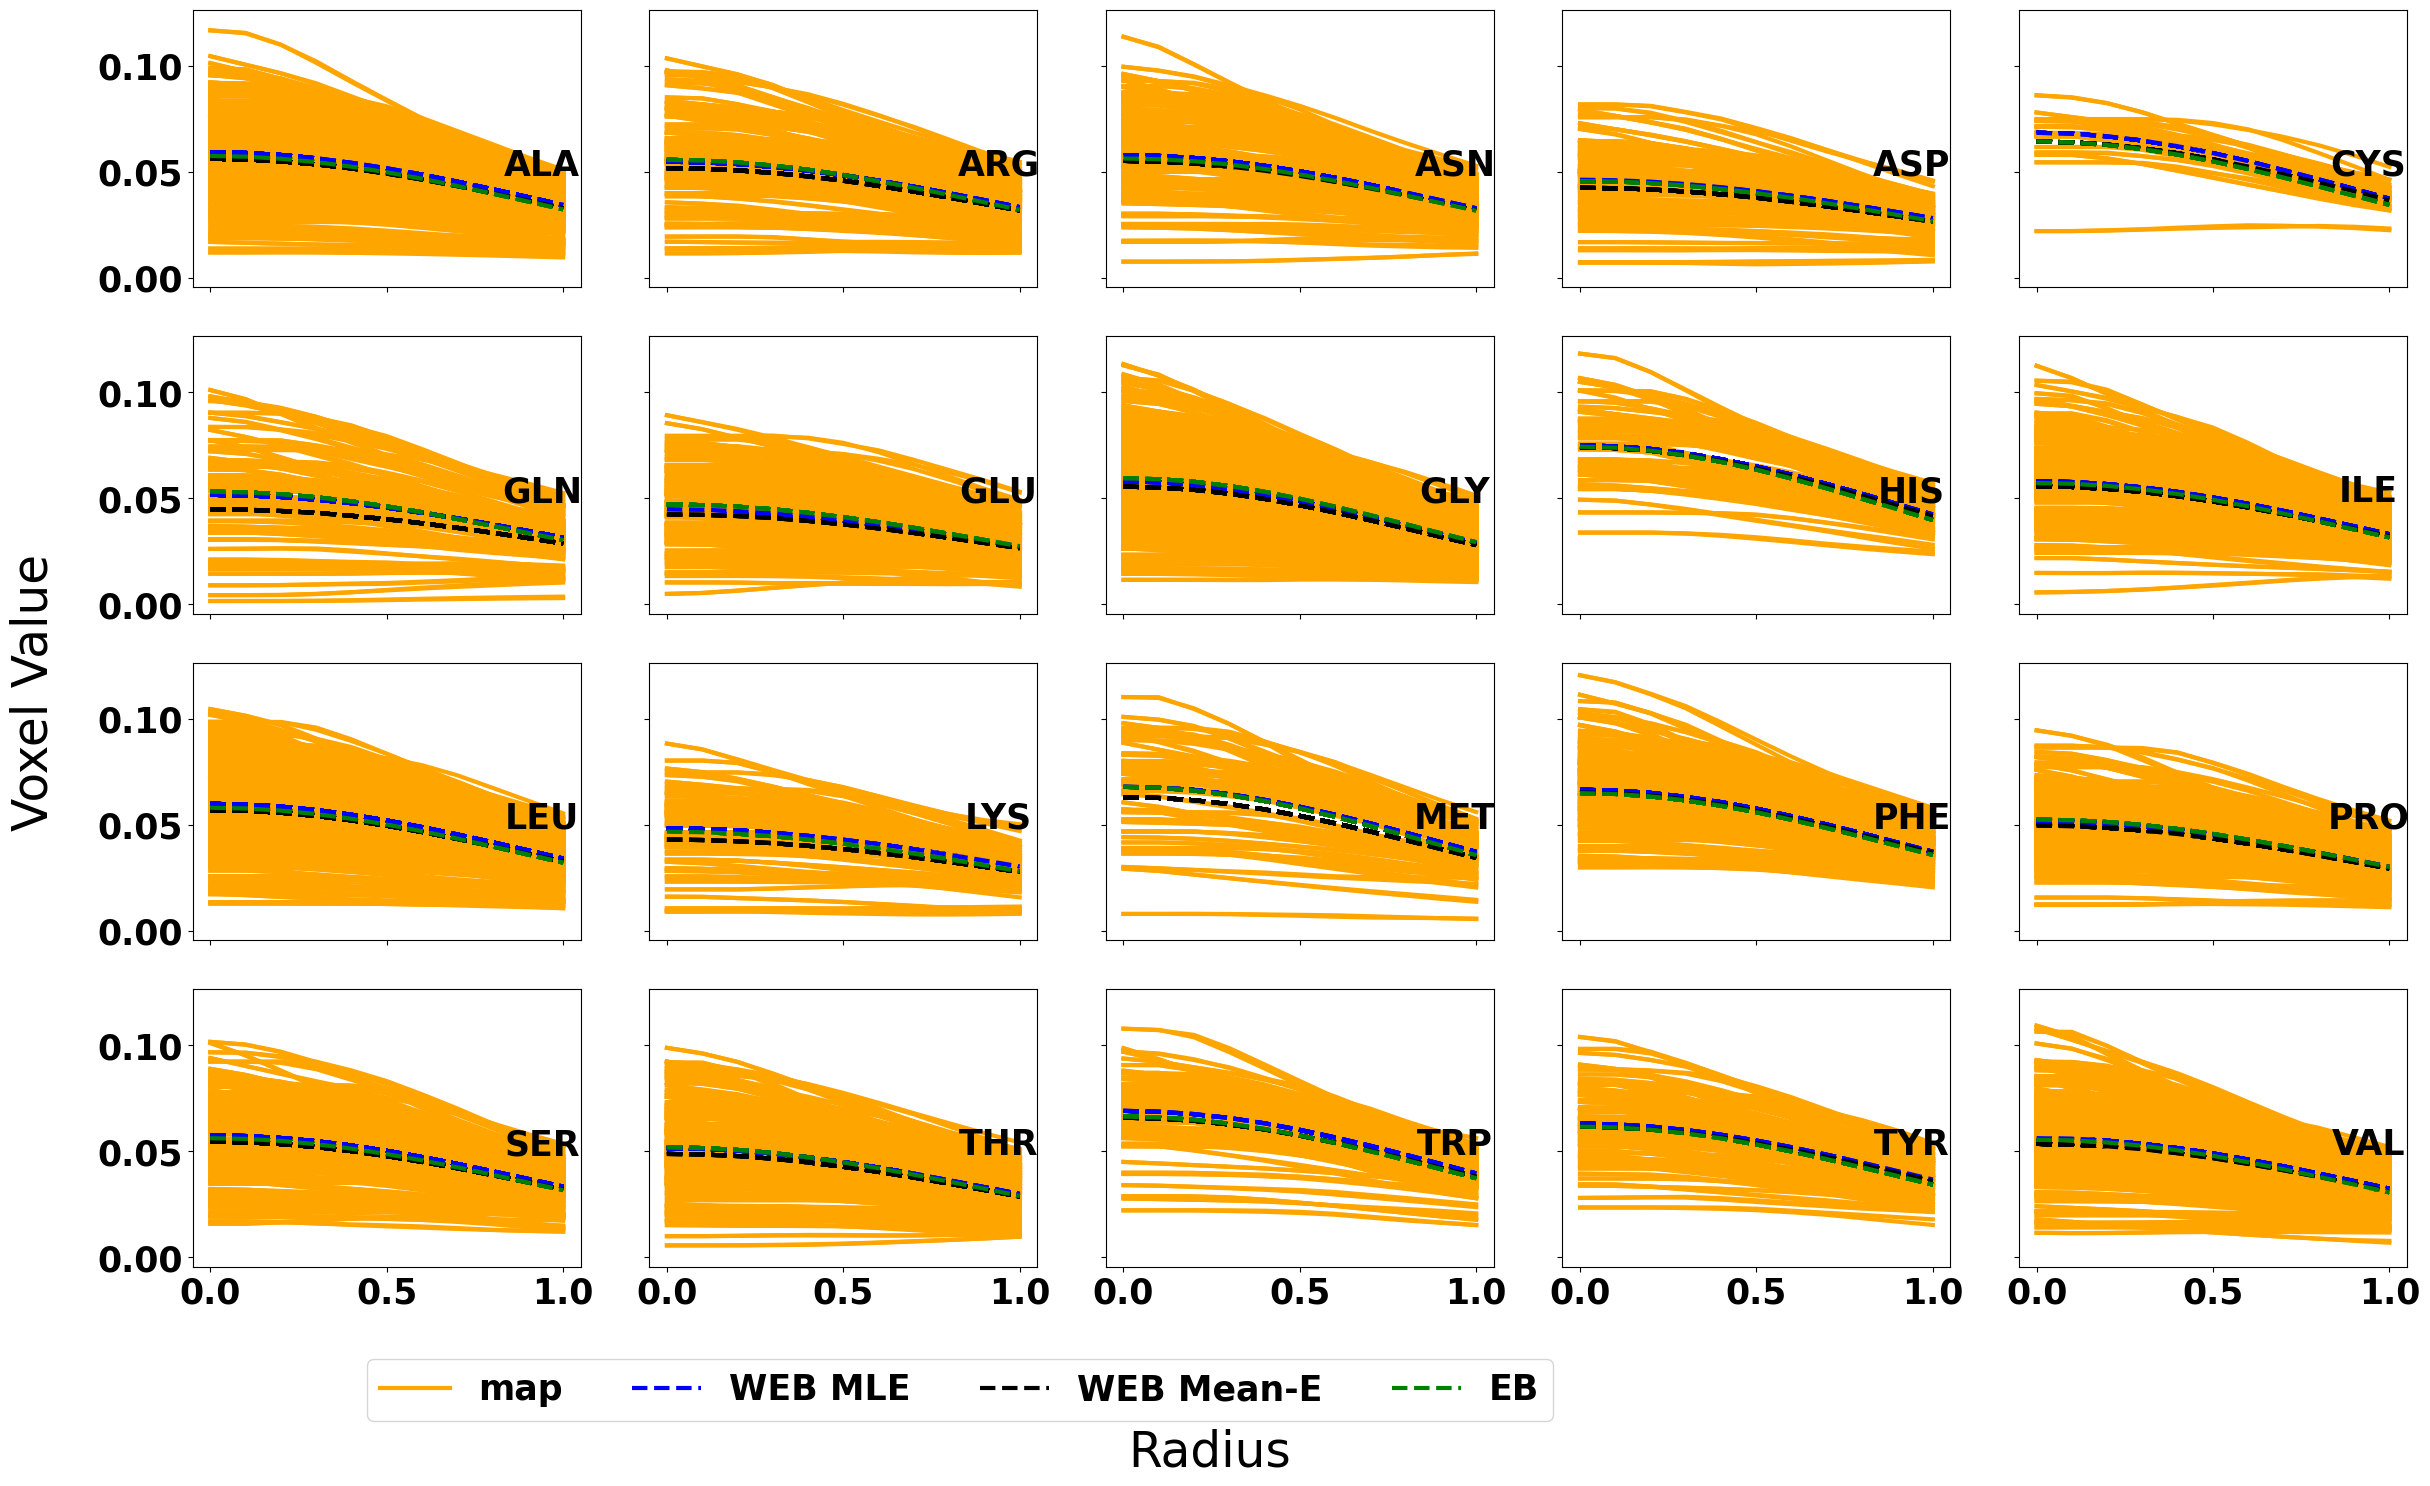

In [90]:
web.representative_densities_plot(
    # root = f"./figures/densities_compared_{PROTEIN}_{EM_MAP}_EB", 
    estimators = ["WEB MLE", "WEB Mean-E", "EB"]
    )

<Figure size 640x480 with 0 Axes>

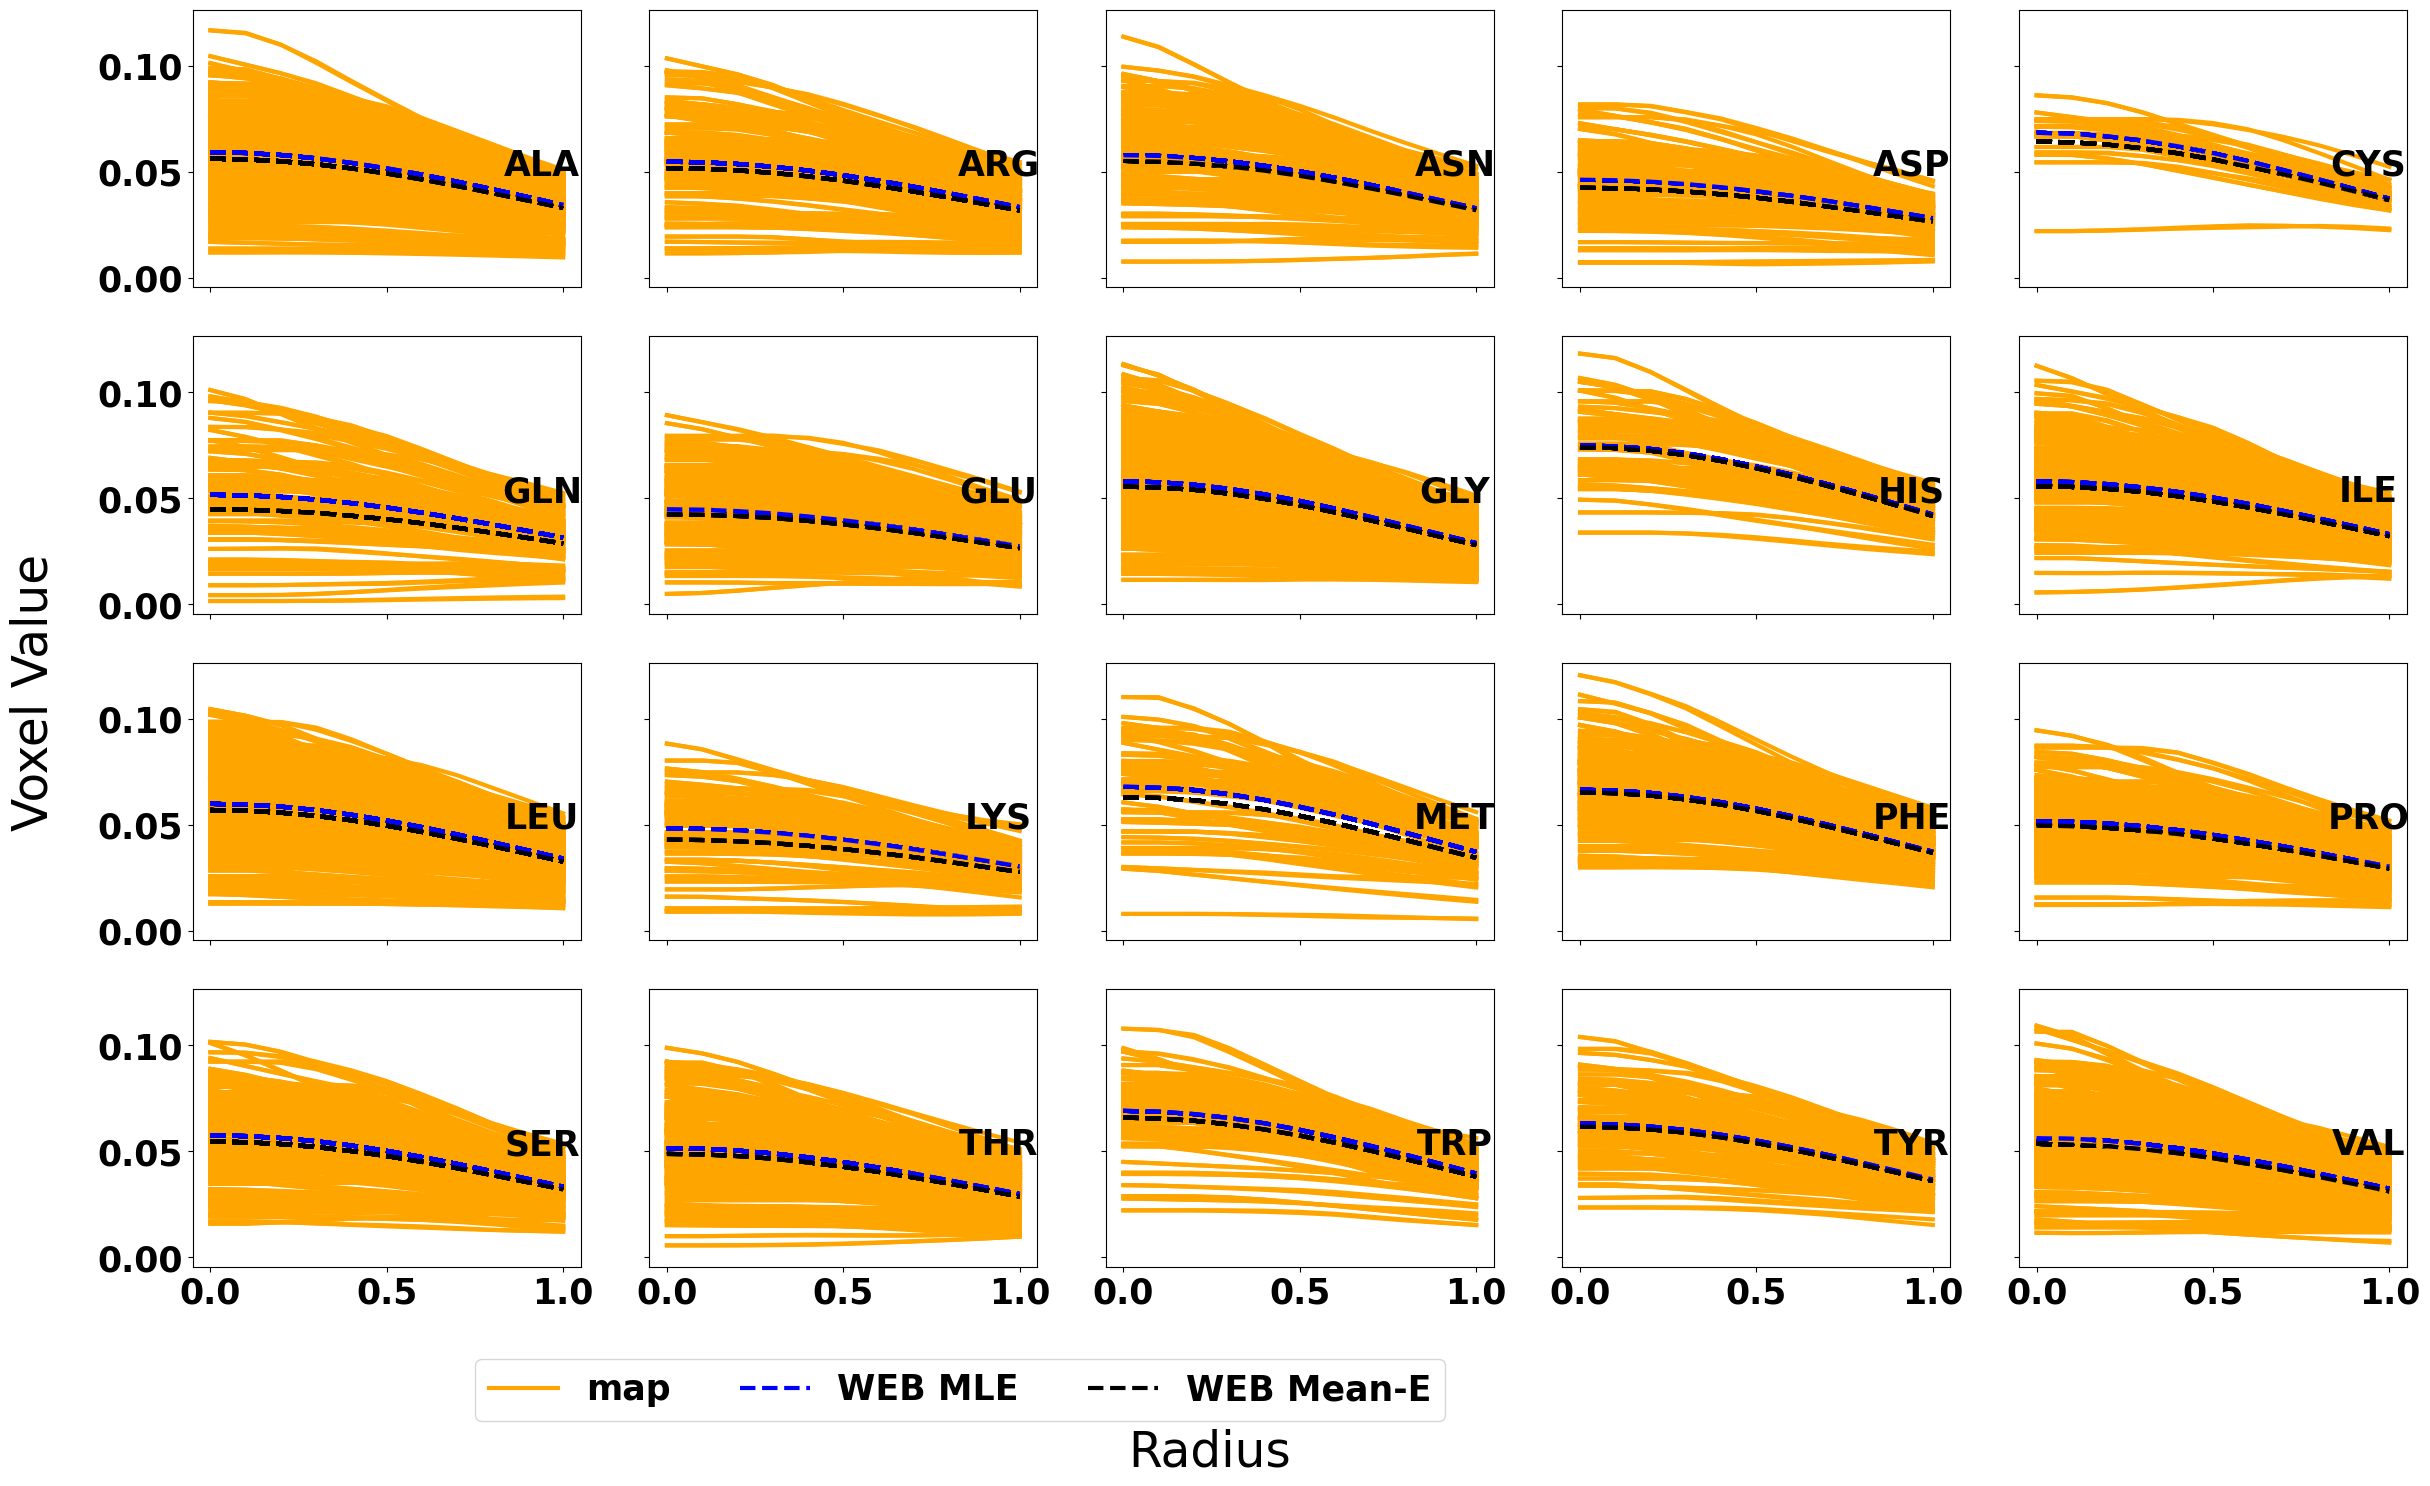

In [91]:
web.representative_densities_plot(
    # root = f"./figures/densities_compared_{PROTEIN}_{EM_MAP}", 
    estimators = ["WEB MLE", "WEB Mean-E"]
    )

### Find outliers

In [97]:
outliers, statistic_distances = web.find_outliers3(prob=0.95)

In [98]:
for key, value in outliers.items():
    print(key, value)

ALA [0, 54, 58, 72, 84, 113, 125, 132, 138, 153, 168, 222, 272, 283, 294, 306, 327, 337, 361, 376, 390, 392, 395, 405, 407, 417, 421, 422, 430, 435, 451]
ARG [3, 27, 29, 32, 33, 41, 58, 66, 91, 104, 117, 159, 163, 172, 181, 188, 207, 213, 218]
ASN [12, 87, 88, 128, 129, 134, 158, 176, 181, 189, 199]
ASP [40, 54, 78, 102, 115, 116, 122, 134, 137, 153, 154, 155]
CYS [8, 12, 30]
GLN [6, 18, 66, 75, 78, 87, 95, 140, 142, 150, 154]
GLU [26, 57, 63, 69, 73, 81, 84, 102, 109, 208, 218, 223, 228, 248, 250, 262]
GLY [24, 47, 56, 65, 77, 84, 91, 101, 127, 142, 150, 156, 173, 186, 189, 190, 199, 205, 240, 256, 272, 309, 340, 345, 364, 378, 379, 388, 398, 462, 470, 481, 482, 501]
HIS [27, 35, 37, 55, 74, 96, 100, 103]
ILE [3, 14, 16, 34, 83, 99, 107, 122, 136, 156, 157, 170, 175, 255, 278]
LEU [5, 23, 47, 50, 69, 70, 75, 78, 95, 109, 122, 140, 172, 198, 206, 212, 250, 251, 271, 275, 304, 315, 346, 380, 437, 469, 506, 530, 540, 541, 543, 544, 545, 546, 548, 551, 555, 557, 561]
LYS [11, 33, 37, 64, 

In [104]:
for key, value in outliers.items():
    print(key, np.array(q_scores[key])[value])

ALA [0.40668357 0.48281839 0.60867376 0.2633544  0.59207186 0.05345104
 0.1958875  0.51668982 0.2527457  0.59961933 0.12765816 0.23428756
 0.22747894 0.91751344 0.35523018 0.42780988 0.75702308 0.78448566
 0.62686017 0.33139618 0.27915848 0.01765747 0.35300209 0.18067429
 0.29042999 0.2847271  0.34859253 0.11497239 0.28257032 0.29664305
 0.32361207]
ARG [ 0.61178538  0.02931692  0.41172002  0.82452446  0.67497912  0.10503132
 -0.1918767   0.291769    0.60637345  0.52786047 -0.00131232 -0.09899423
 -0.51766452  0.12470513 -0.28456283  0.48726872  0.83356016  0.2083348
 -0.1876323 ]
ASN [ 0.53876632  0.19749314 -0.14421726 -0.05643763  0.763395    0.31541063
 -0.32941397 -0.3488073   0.4443875   0.23646153  0.49532699]
ASP [ 0.76403322 -0.05709273  0.40676865  0.60206804 -0.02944404 -0.10600134
 -0.04780343 -0.04383086  0.58049042  0.08129307 -0.10833259 -0.0279227 ]
CYS [ 0.49688079 -0.12617824 -0.14557624]
GLN [ 0.54003057  0.2140783   0.43638554 -0.39165467 -0.29737426 -0.29743807
 -0

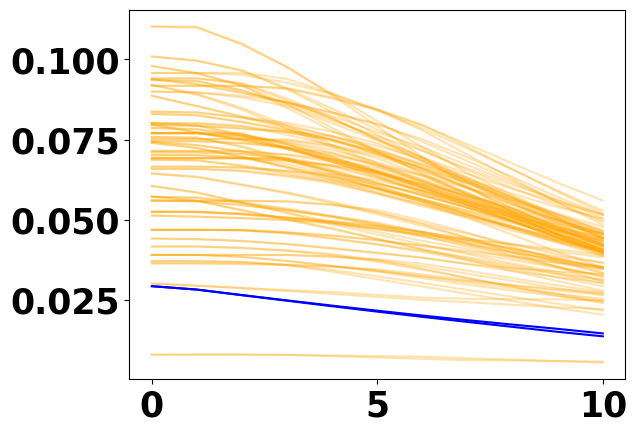

In [109]:
for i, density in enumerate(web.densities_data["MET"]):
    plt.plot(web.d)
    if i in [9, 90]:
        plt.plot(density, color="blue")
    else:
        plt.plot(density, color="orange", alpha=0.3)

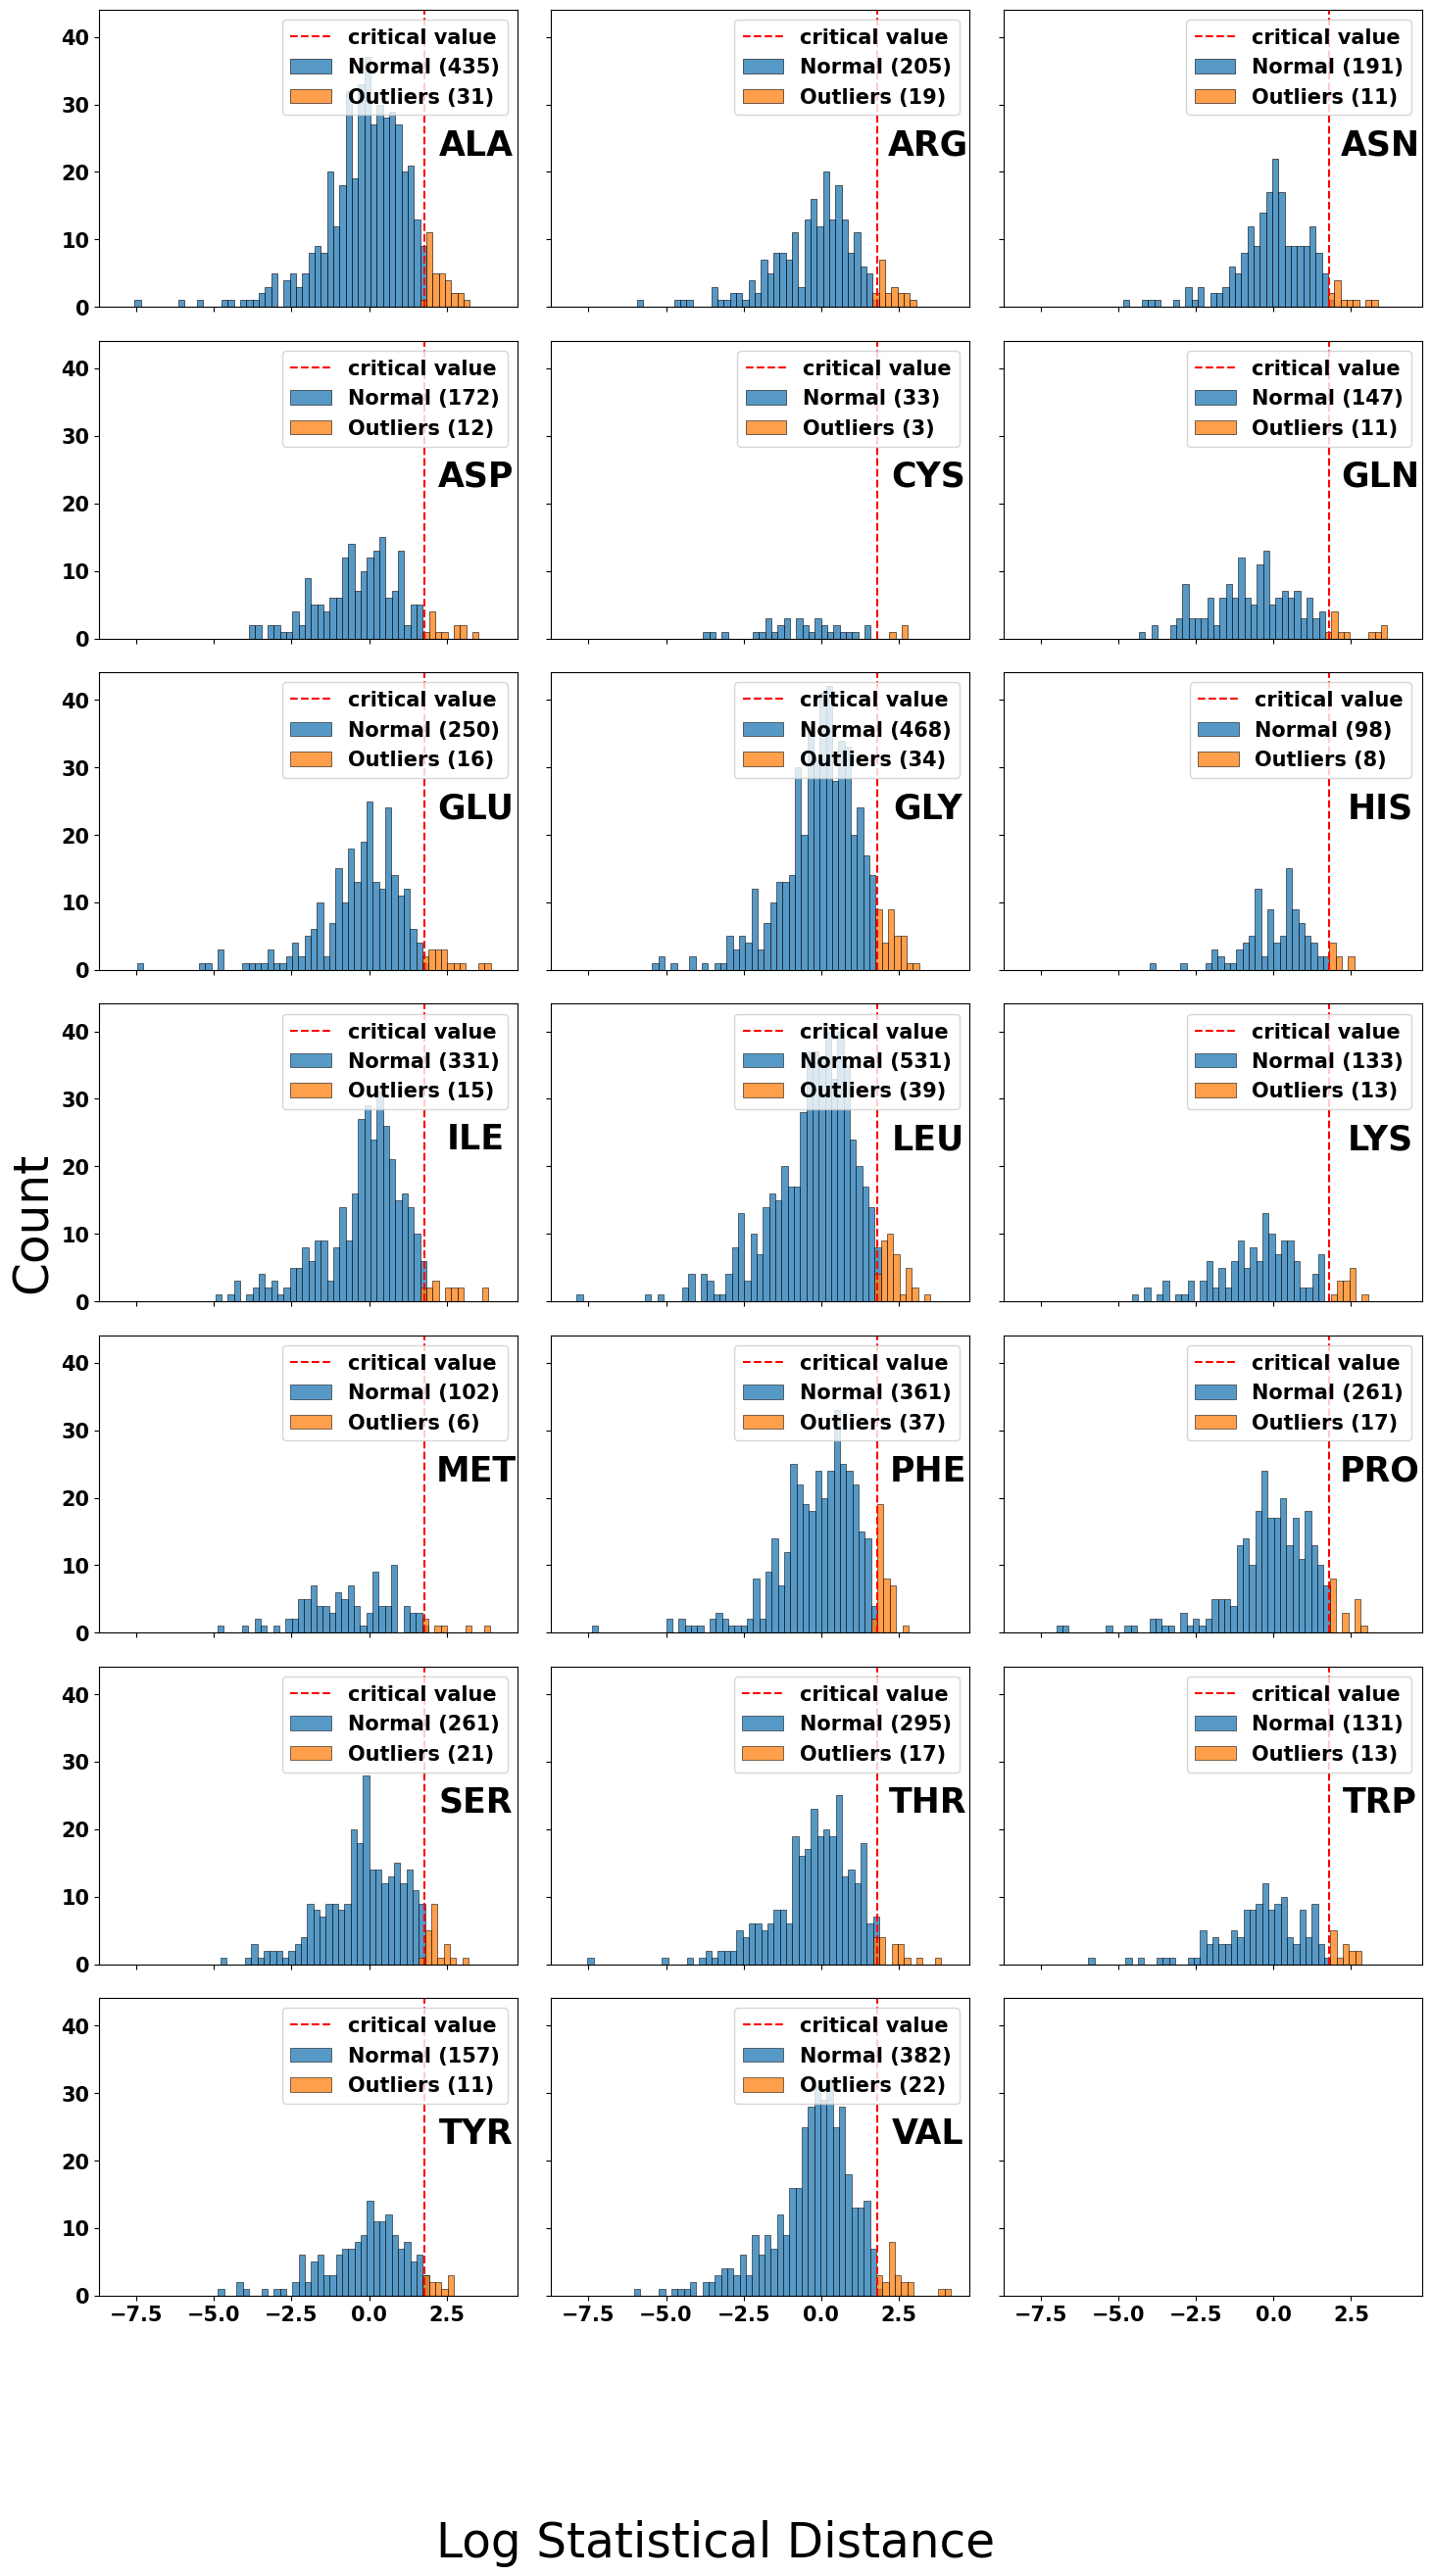

In [99]:
web.distances_hist(
    # f"./figures/distances_hist_{PROTEIN}_{EM_MAP}"
)

<Figure size 640x480 with 0 Axes>

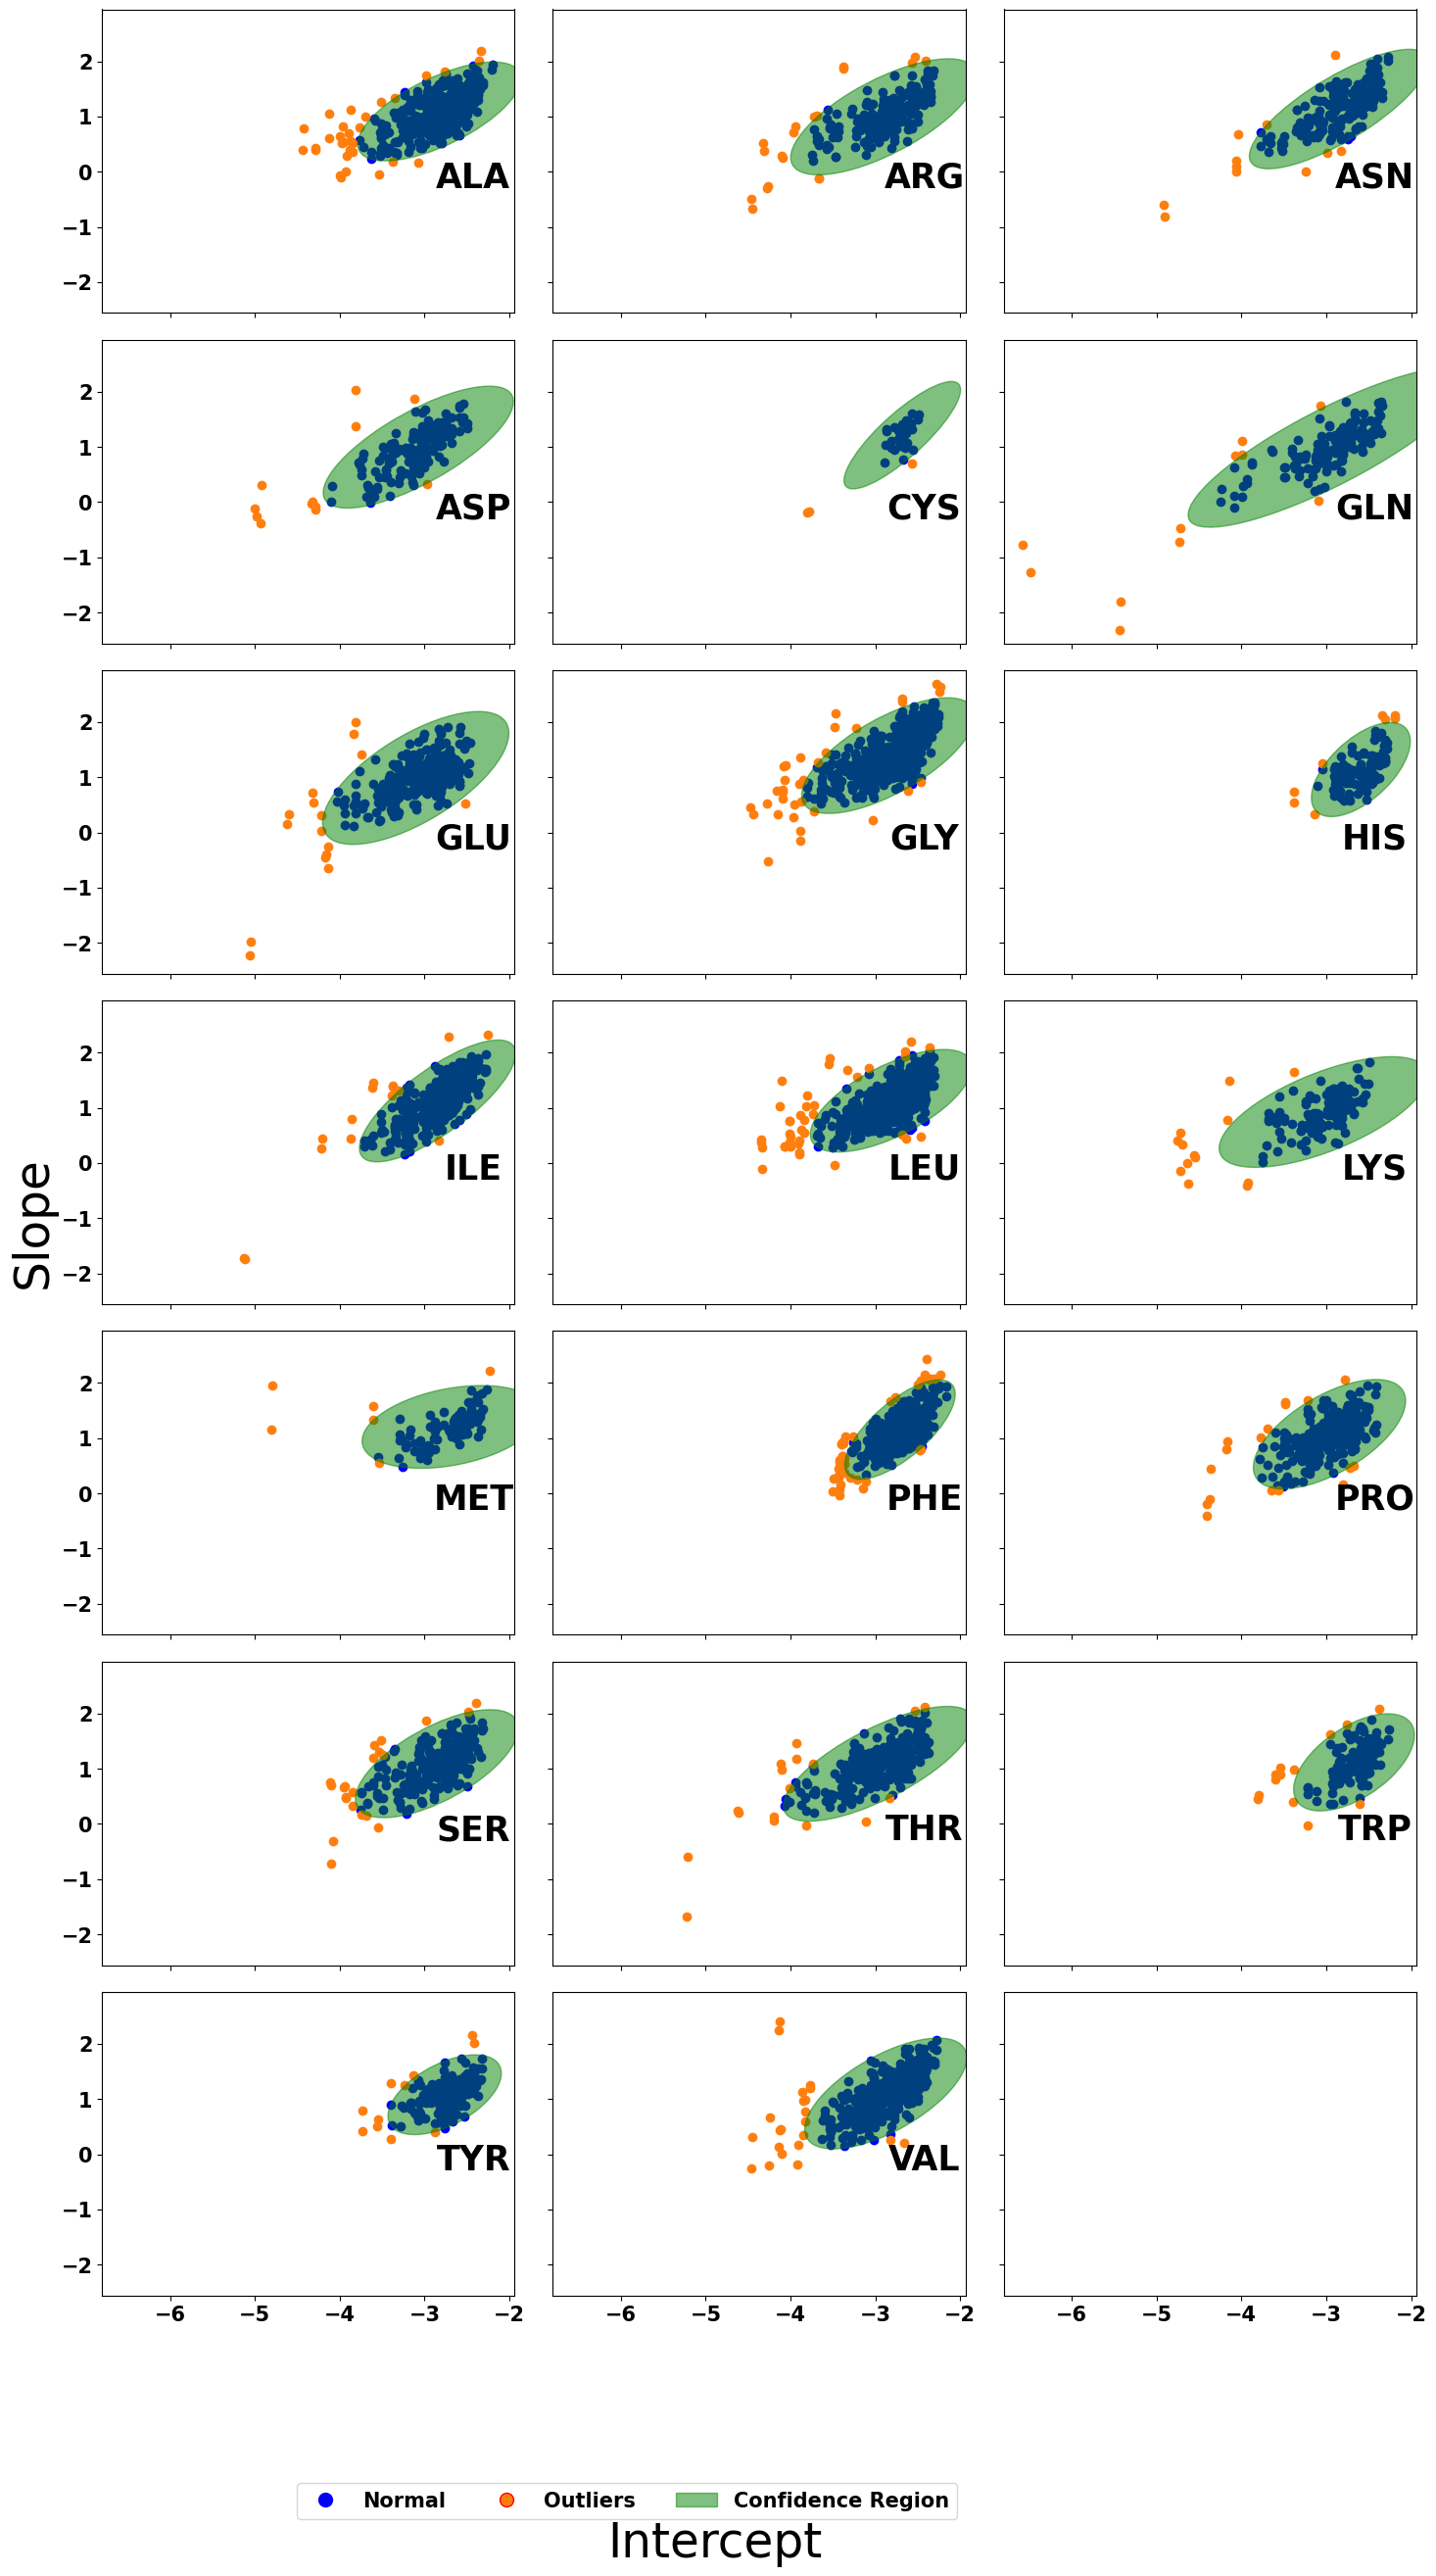

In [100]:
web.confidence_regions_plot(
    # f"./figures/confidence_regions_plot_{PROTEIN}_{EM_MAP}"
    )

<Figure size 640x480 with 0 Axes>

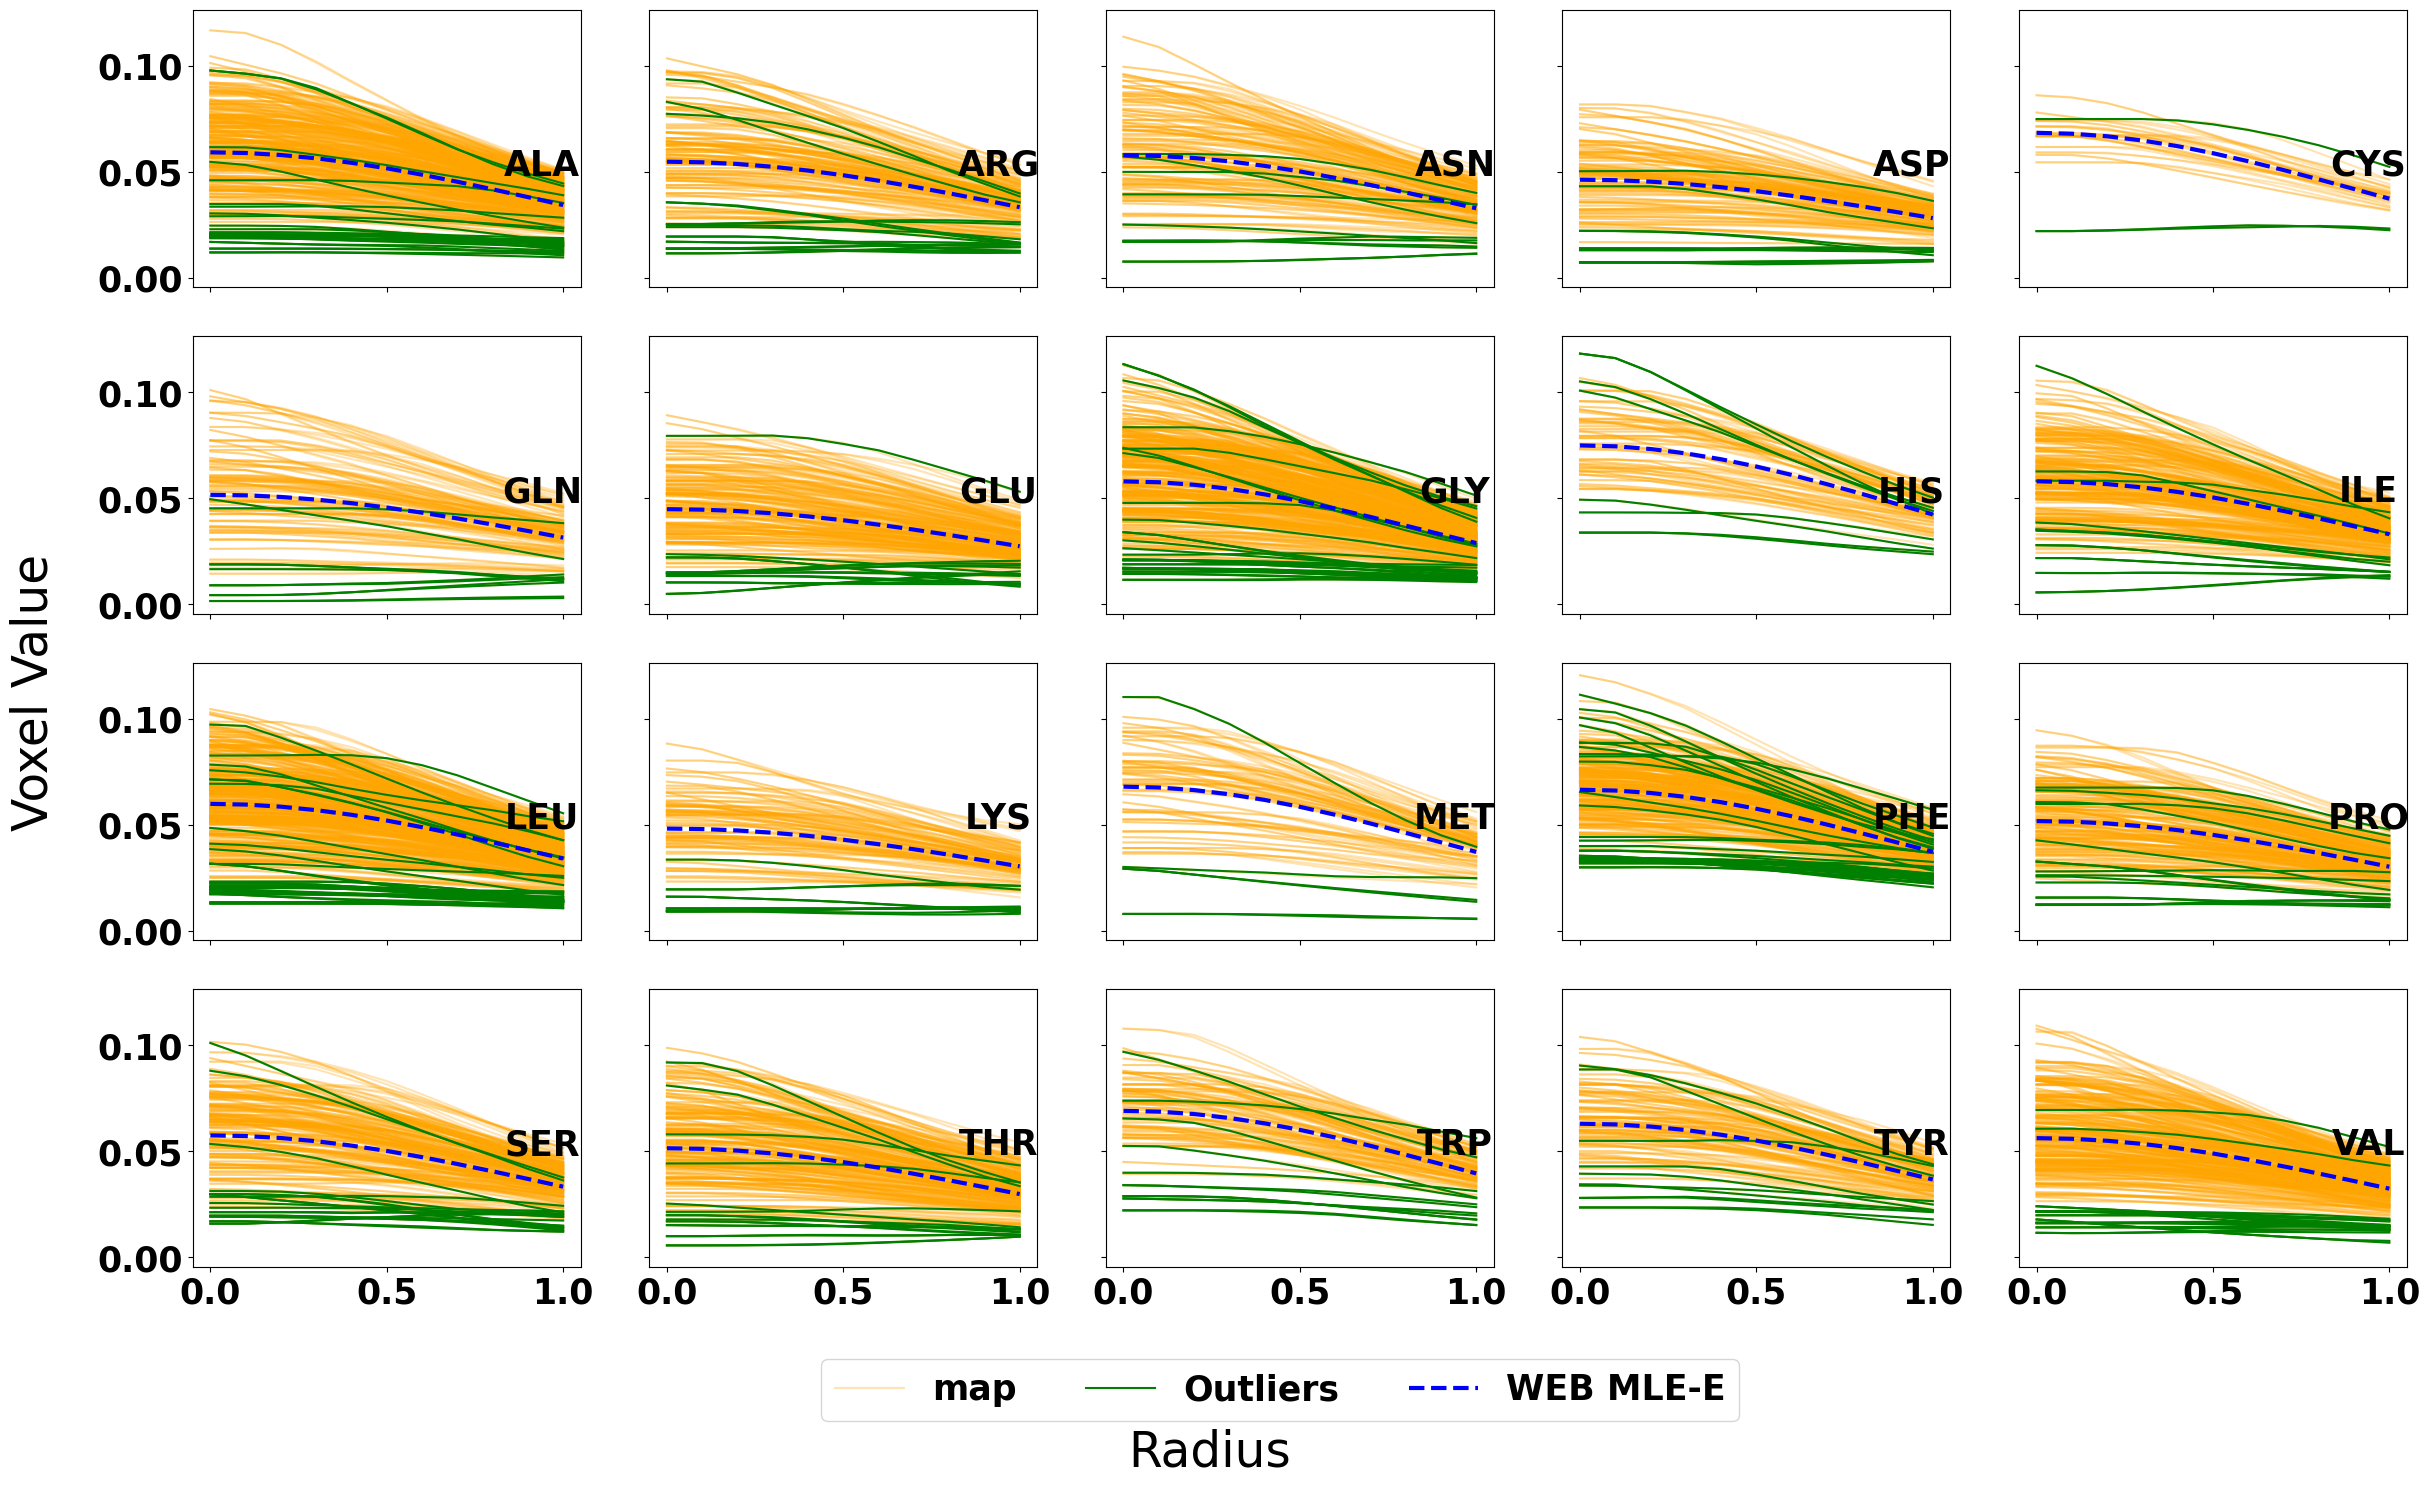

In [101]:
web.outliers_density_plot(
    # f"./figures/outliers_density_plot_{PROTEIN}_{EM_MAP}"
    )

In [42]:
atoms = ["CA", "C", "N", "O"]
webs = {atom: None for atom in atoms}
for atom in webs:
    web = WEB(start_radius=0, max_radius=1, gap=0.2)
    data = web.read_data(
        root_map=root_map, 
        root_pdb=root_pdb,
        atoms=[atom],
        base_num_points=BASE_NUM_POINTS, 
        max_points=MAX_POINTS
        )
    _ = web.paramters_initial()
    _ = web.WEB_iter_test2(max_iter=MAX_ITER, alpha=ALPHA, gamma=GAMMA, tol=TOL)
    webs[atom] = web

100%|██████████| 5300/5300 [00:04<00:00, 1200.23it/s]
INFO:root:ALA MDPDE finished in iteration: 71
INFO:root:ALA WEB finished in iteration: 28
INFO:root:===================================
INFO:root:ARG MDPDE finished in iteration: 73
INFO:root:ARG WEB finished in iteration: 43
INFO:root:===================================
INFO:root:ASN MDPDE finished in iteration: 58
INFO:root:ASN WEB finished in iteration: 20
INFO:root:===================================
INFO:root:ASP MDPDE finished in iteration: 64
INFO:root:ASP WEB finished in iteration: 26
INFO:root:===================================
INFO:root:CYS MDPDE finished in iteration: 12
INFO:root:CYS WEB finished in iteration: 43
INFO:root:===================================
INFO:root:GLN MDPDE finished in iteration: 64
INFO:root:GLN WEB finished in iteration: 35
INFO:root:===================================
INFO:root:GLU MDPDE finished in iteration: 75
INFO:root:GLU WEB finished in iteration: 23
INFO:root:==============================

In [43]:
def solve(beta):
    beta_0, beta_1 = beta
    tau = 1 / beta_1
    A = np.exp(beta_0 + 3 / 2 * np.log(beta_1))
    return tau, A

In [44]:
estimators_atom = {}
for atom in webs:
    estimators_list = list(map(solve, webs[atom].mus_mle.values()))
    estimators = {name: estimator for name, estimator in zip(webs[atom].mus_mle, estimators_list)}
    estimators_atom[atom] = estimators

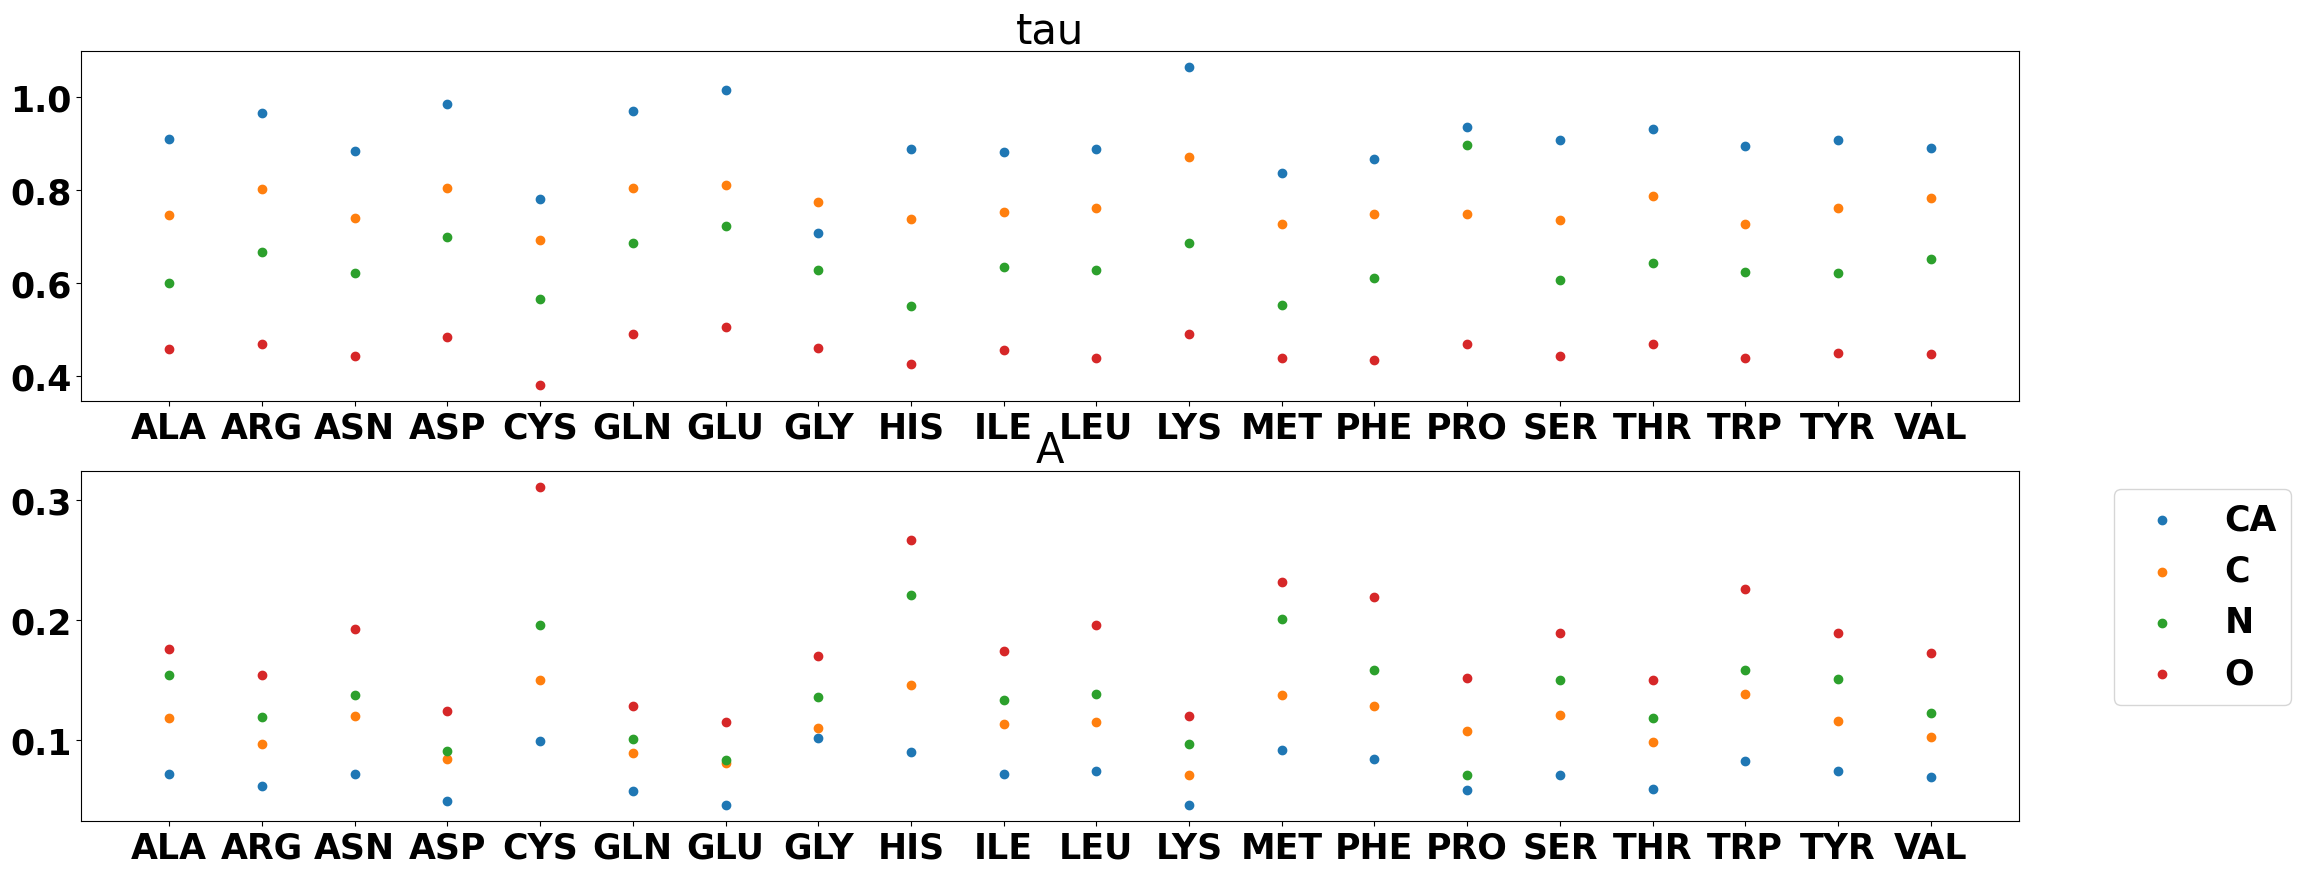

In [45]:
fig, ax = plt.subplots(2, 1, figsize=(25, 10))
for atom in estimators_atom:
    X_axis = estimators_atom[atom].keys()
    Y_axis = np.array(list(estimators_atom[atom].values()))
    ax[0].scatter(X_axis, Y_axis[:, 0], label=atom)
    ax[1].scatter(X_axis, Y_axis[:, 1], label=atom)
    ax[0].set_title("tau")
    ax[1].set_title("A")
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")

In [7]:
web_CCON = WEB(start_radius=0, max_radius=1, gap=0.2)
data = web_CCON.read_data(
    root_map=f'./dataset/emd_{EM_MAP}.map', 
    root_pdb=f'./dataset/{PROTEIN}.pdb',
    atoms=atoms,
    base_num_points=BASE_NUM_POINTS, 
    max_points=MAX_POINTS
    )
_ = web_CCON.paramters_initial()
_ = web_CCON.WEB_iter_test2(max_iter=MAX_ITER, alpha=ALPHA, gamma=GAMMA, tol=TOL)

100%|██████████| 21200/21200 [00:26<00:00, 787.97it/s]
INFO:root:ALA MDPDE finished in iteration: 52
INFO:root:ALA WEB finished in iteration: 30
INFO:root:===================================
INFO:root:ARG MDPDE finished in iteration: 57
INFO:root:ARG WEB finished in iteration: 34
INFO:root:===================================
INFO:root:ASN MDPDE finished in iteration: 49
INFO:root:ASN WEB finished in iteration: 34
INFO:root:===================================
INFO:root:ASP MDPDE finished in iteration: 55
INFO:root:ASP WEB finished in iteration: 30
INFO:root:===================================
INFO:root:CYS MDPDE finished in iteration: 51
INFO:root:CYS WEB finished in iteration: 45
INFO:root:===================================
INFO:root:GLN MDPDE finished in iteration: 58
INFO:root:GLN WEB finished in iteration: 26
INFO:root:===================================
INFO:root:GLU MDPDE finished in iteration: 59
INFO:root:GLU WEB finished in iteration: 24
INFO:root:=============================

In [8]:
estimators_list_CCON = list(map(solve, web_CCON.mus_mle.values()))
estimators_CCON = {name: estimator for name, estimator in zip(web_CCON.mus_mle, estimators_list_CCON)}

In [9]:
web_all = WEB(start_radius=0, max_radius=1, gap=0.2)
data = web_all.read_data(
    root_map=f'./dataset/emd_{EM_MAP}.map', 
    root_pdb=f'./dataset/{PROTEIN}.pdb',
    atoms=None,
    base_num_points=BASE_NUM_POINTS, 
    max_points=MAX_POINTS
    )
_ = web_all.paramters_initial()
_ = web_all.WEB_iter_test2(max_iter=MAX_ITER, alpha=ALPHA, gamma=GAMMA, tol=TOL)

100%|██████████| 41574/41574 [00:52<00:00, 785.55it/s]
INFO:root:ALA MDPDE finished in iteration: 52
INFO:root:ALA WEB finished in iteration: 29
INFO:root:===================================
INFO:root:ARG MDPDE finished in iteration: 57
INFO:root:ARG WEB finished in iteration: 26
INFO:root:===================================
INFO:root:ASN MDPDE finished in iteration: 52
INFO:root:ASN WEB finished in iteration: 28
INFO:root:===================================
INFO:root:ASP MDPDE finished in iteration: 64
INFO:root:ASP WEB finished in iteration: 25
INFO:root:===================================
INFO:root:CYS MDPDE finished in iteration: 51
INFO:root:CYS WEB finished in iteration: 44
INFO:root:===================================
INFO:root:GLN MDPDE finished in iteration: 58
INFO:root:GLN WEB finished in iteration: 24
INFO:root:===================================
INFO:root:GLU MDPDE finished in iteration: 59
INFO:root:GLU WEB finished in iteration: 25
INFO:root:=============================

In [10]:
estimators_list_all = list(map(solve, web_all.mus_mle.values()))
estimators_all = {name: estimator for name, estimator in zip(web_all.mus_mle, estimators_list_all)}

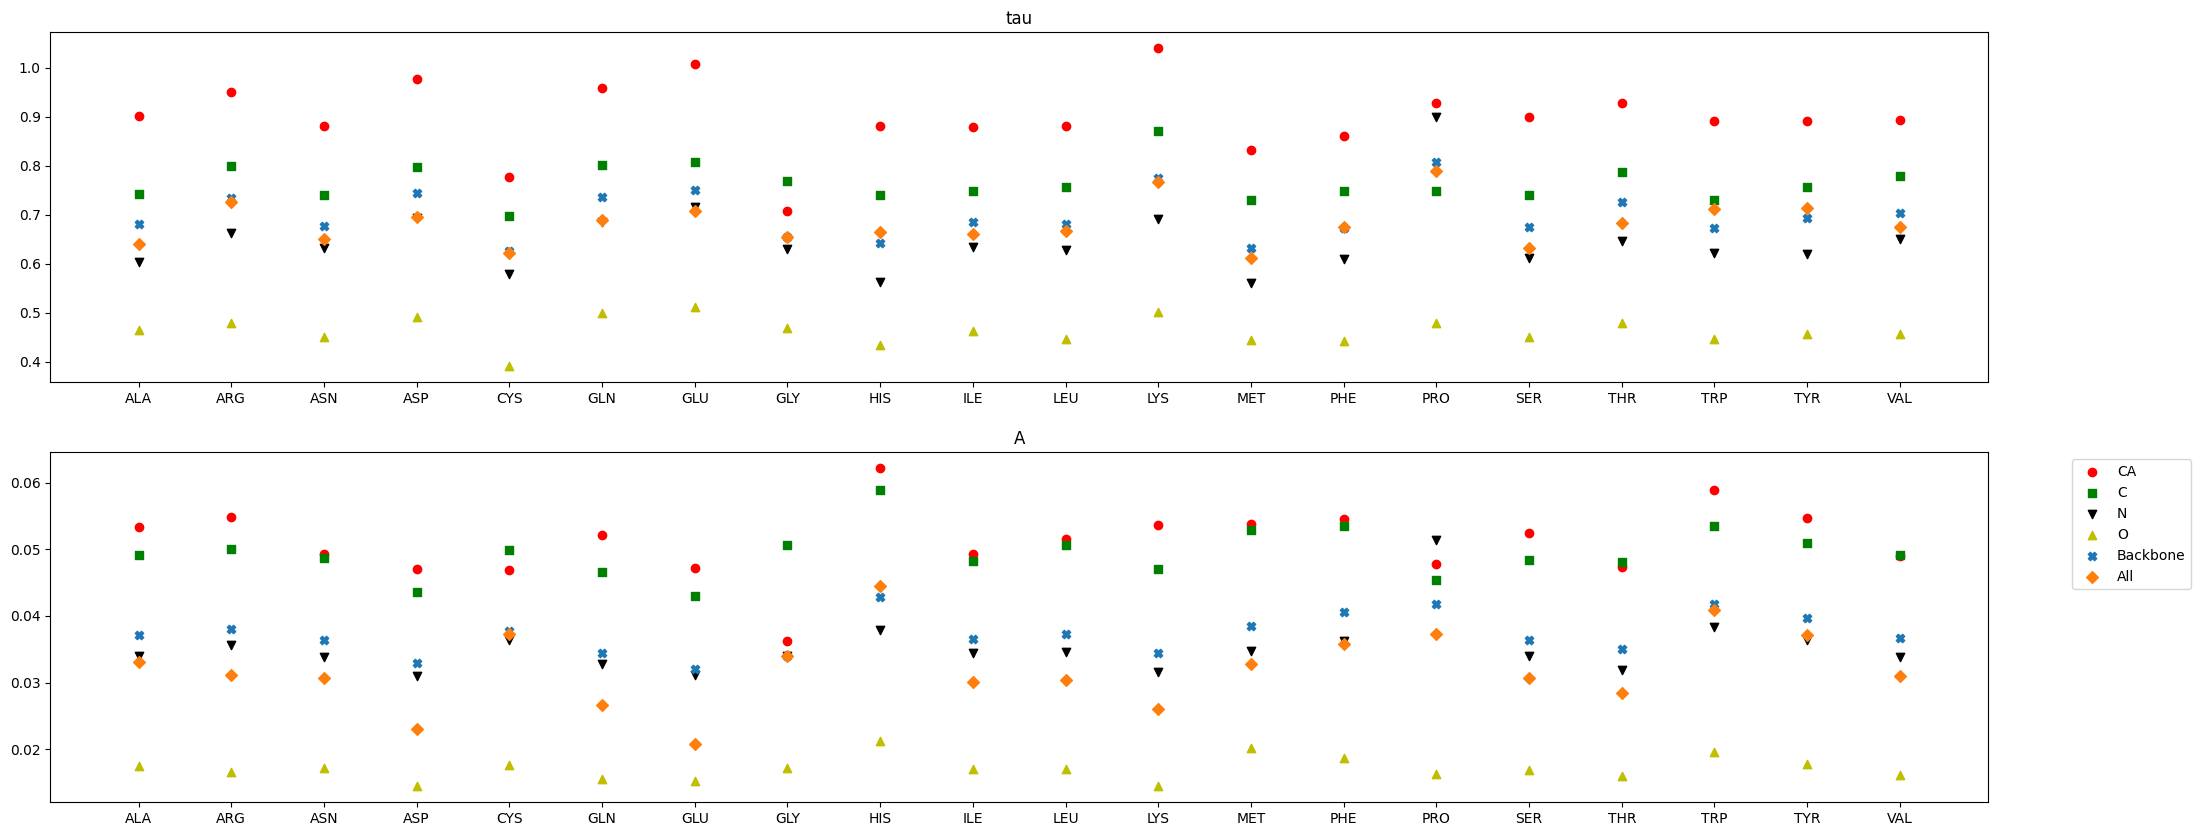

In [11]:
fig, ax = plt.subplots(2, 1, figsize=(25, 10))
colors = ["r", "g", "black", "y"]
shapes = ["o", "s", "v", "^"]
for atom, shape, color in zip(estimators_atom, shapes, colors):
    X_axis = estimators_atom[atom].keys()
    Y_axis = np.array(list(estimators_atom[atom].values()))
    ax[0].scatter(X_axis, Y_axis[:, 0], label=atom, marker=shape, c=color)
    ax[1].scatter(X_axis, Y_axis[:, 1], label=atom, marker=shape, c=color)
    ax[0].set_title("tau")
    ax[1].set_title("A")
Y_axis_CCON = np.array(list(estimators_CCON.values()))
ax[0].scatter(X_axis, Y_axis_CCON[:, 0], label="Backbone", marker="X")
ax[1].scatter(X_axis, Y_axis_CCON[:, 1], label="Backbone", marker="X")
Y_axis_all = np.array(list(estimators_all.values()))
ax[0].scatter(X_axis, Y_axis_all[:, 0], label="All", marker="D")
ax[1].scatter(X_axis, Y_axis_all[:, 1], label="All", marker="D")
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")

In [12]:
import scipy
def F_test(SSE_all, SSE_alone, df1, df2):
    SSE_delta = SSE_all - SSE_alone
    return (SSE_delta / df1) / (SSE_alone / df2)

In [13]:
residues = ["ALA", "ARG", "ASN", "ASP", "CYS", "GLN", "GLU", "GLY", "HIS", "ILE", "LEU", "LYS", "MET", "PHE", "PRO", "SER", "THR", "TRP", "TYR", "VAL"]
F_scores = {residue: None for residue in residues}
p_values = {residue: None for residue in residues}
# residues = ["HIS"]
for residue in residues:
    SSE_separate = 0
    SSE_CCON = 0
    SSE_all = 0
    data_densities_len = 0
    for atom in webs:
        X_tilde = webs[atom].Xs_tilde[residue][0]
        estimated_densities_separate = X_tilde @ webs[atom].mus_mle[residue] @ webs[atom].Xs_tilde[residue][0].T
        estimated_densities_CCON = (web_CCON.betas_WEB[residue] @ web_CCON.Xs_tilde[residue][0].T)[np.where(web_CCON.atoms_order[residue] == atom)]
        estimated_densities_all = (web_all.betas_WEB[residue] @ web_all.Xs_tilde[residue][0].T)[np.where(web_CCON.atoms_order[residue] == atom)]
        data_densities = webs[atom].data[residue]
        
        SSE_separate += np.sum((estimated_densities_separate - data_densities) ** 2)
        SSE_CCON += np.sum((estimated_densities_CCON - data_densities) ** 2)
        SSE_all += np.sum((estimated_densities_all - data_densities) ** 2)
        data_densities_len += data_densities.shape[0] * data_densities.shape[1]

        df1 = 6
        df2 = data_densities_len - 8
        
        F_scores[residue] = F_test(SSE_CCON, SSE_separate, df1, df2)
        p_values[residue] = scipy.stats.f.sf(F_scores[residue], df1, df2)

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 2 is different from 1501)

In [ ]:
F_scores

{'ALA': 557.7834819454911,
 'ARG': 257.33007224780414,
 'ASN': 222.81981282066525,
 'ASP': 149.29592249931554,
 'CYS': 14.122648225590641,
 'GLN': 218.28469240722646,
 'GLU': 228.74484103412888,
 'GLY': 543.287826687553,
 'HIS': 70.68649433765776,
 'ILE': 336.20759865846674,
 'LEU': 531.5607027976399,
 'LYS': 120.44074308477234,
 'MET': 146.07523569861712,
 'PHE': 313.3924072507819,
 'PRO': 266.97870864829866,
 'SER': 319.44463417178844,
 'THR': 414.3684194610697,
 'TRP': 137.6961546573929,
 'TYR': 160.15370383810205,
 'VAL': 451.24234034909324}

In [ ]:
p_values

{'ALA': 0.0,
 'ARG': 0.0,
 'ASN': 1.5889528767342174e-285,
 'ASP': 3.682810913380157e-190,
 'CYS': 3.772691490721336e-16,
 'GLN': 1.3428384681695158e-279,
 'GLU': 2.968623580476668e-293,
 'GLY': 0.0,
 'HIS': 1.949023615169613e-88,
 'ILE': 0.0,
 'LEU': 0.0,
 'LYS': 9.137906099194286e-153,
 'MET': 6.2041172266825115e-186,
 'PHE': 0.0,
 'PRO': 0.0,
 'SER': 0.0,
 'THR': 0.0,
 'TRP': 4.130047348645289e-175,
 'TYR': 3.1694935573969554e-204,
 'VAL': 0.0}

In [13]:
residues = ["ALA", "ARG", "ASN", "ASP", "CYS", "GLN", "GLU", "GLY", "HIS", "ILE", "LEU", "LYS", "MET", "PHE", "PRO", "SER", "THR", "TRP", "TYR", "VAL"]

F_scores_all_separate = {residue: None for residue in residues}
p_values_all_separate = {residue: None for residue in residues}

F_scores_all_CCON = {residue: None for residue in residues}
p_values_all_CCON = {residue: None for residue in residues}


# residues = ["HIS"]
for residue in residues:
    SSE_separate = 0
    SSE_CCON = 0
    SSE_all = 0
    data_densities_len = 0
    for atom in webs:
        X_tilde = webs[atom].Xs_tilde[residue][0]
        estimated_densities_separate = np.exp(X_tilde @ webs[atom].mus_mle[residue])
        estimated_densities_CCON = np.exp(X_tilde @ web_CCON.mus_mle[residue])
        estimated_densities_all = np.exp(X_tilde @ web_all.mus_mle[residue])
        
        data_densities = webs[atom].data[residue]
        
        SSE_separate += np.sum((estimated_densities_separate - data_densities) ** 2)
        SSE_CCON += np.sum((estimated_densities_CCON - data_densities) ** 2)
        SSE_all += np.sum((estimated_densities_all - data_densities) ** 2)
        data_densities_len += data_densities.shape[0] * data_densities.shape[1]

        # df11 = 2
        # df12 = data_densities_len - 
        
        df21 = 6
        df22 = data_densities_len - 8

        # F_scores_all_separate[residue] = F_test(SSE_all, SSE_separate, df11, df12)
        # p_values_all_separate[residue] = scipy.stats.f.sf(F_scores[residue], df11, df12)

        F_scores_all_CCON[residue] = F_test(SSE_CCON, SSE_separate, df21, df22)
        p_values_all_CCON[residue] = scipy.stats.f.sf(F_scores_all_CCON[residue], df21, df22)

In [14]:
p_values_all_CCON

{'ALA': 0.0,
 'ARG': 0.0,
 'ASN': 0.0,
 'ASP': 0.0,
 'CYS': 0.0,
 'GLN': 0.0,
 'GLU': 0.0,
 'GLY': 0.0,
 'HIS': 0.0,
 'ILE': 0.0,
 'LEU': 0.0,
 'LYS': 0.0,
 'MET': 0.0,
 'PHE': 0.0,
 'PRO': 0.0,
 'SER': 0.0,
 'THR': 0.0,
 'TRP': 0.0,
 'TYR': 0.0,
 'VAL': 0.0}

In [37]:
F_scores_all_CCON

{'ALA': 42568.340977648055,
 'ARG': 18592.577063209457,
 'ASN': 18594.313237594488,
 'ASP': 17712.55749657284,
 'CYS': 4631.498557737374,
 'GLN': 10754.965888817133,
 'GLU': 28721.023862696497,
 'GLY': 53610.61016874834,
 'HIS': 15583.980917359087,
 'ILE': 32558.77542033022,
 'LEU': 51172.450452405814,
 'LYS': 13818.929872456945,
 'MET': 9857.860103549277,
 'PHE': 47283.866375119454,
 'PRO': 30385.070090434234,
 'SER': 23088.68722645381,
 'THR': 22250.741080537216,
 'TRP': 15522.923202202974,
 'TYR': 19838.321672557653,
 'VAL': 38183.170059832075}

In [15]:
atoms = ["CA", "C", "N", "O"]
residues = ["ALA", "ARG", "ASN", "ASP", "CYS", "GLN", "GLU", "GLY", "HIS", "ILE", "LEU", "LYS", "MET", "PHE", "PRO", "SER", "THR", "TRP", "TYR", "VAL"]
webs_atom_all = {atom: None for atom in atoms}
webs_atom_three = {atom: None for atom in atoms}
webs_atom_separate = {atom: None for atom in atoms}
for atom in webs_atom_all:
    web_atom_all = WEB(start_radius=0, max_radius=1, gap=0.2)
    data = web_atom_all.read_data(
        root_map=root_map, 
        root_pdb=root_pdb,
        atoms=[atom],
        base_num_points=BASE_NUM_POINTS, 
        max_points=MAX_POINTS, 
        mode = "all"
        )
    _ = web_atom_all.paramters_initial()
    _ = web_atom_all.WEB_iter_test2(max_iter=MAX_ITER, alpha=ALPHA, gamma=GAMMA, tol=TOL)
    webs_atom_all[atom] = web_atom_all

    web_atom_three = WEB(start_radius=0, max_radius=1, gap=0.2)
    data = web_atom_three.read_data(
        root_map=root_map, 
        root_pdb=root_pdb,
        atoms=[atom],
        base_num_points=BASE_NUM_POINTS, 
        max_points=MAX_POINTS, 
        mode = "three"
        )
    _ = web_atom_three.paramters_initial()
    _ = web_atom_three.WEB_iter_test2(max_iter=MAX_ITER, alpha=ALPHA, gamma=GAMMA, tol=TOL)
    webs_atom_three[atom] = web_atom_three

    web_atom_separate = WEB(start_radius=0, max_radius=1, gap=0.2)
    data = web_atom_separate.read_data(
        root_map=root_map, 
        root_pdb=root_pdb,
        atoms=[atom],
        base_num_points=BASE_NUM_POINTS, 
        max_points=MAX_POINTS, 
        mode = "separate"
        )
    _ = web_atom_separate.paramters_initial()
    _ = web_atom_separate.WEB_iter_test2(max_iter=MAX_ITER, alpha=ALPHA, gamma=GAMMA, tol=TOL)
    webs_atom_separate[atom] = web_atom_separate

100%|██████████| 5300/5300 [00:07<00:00, 722.32it/s]
INFO:root:all MDPDE finished in iteration: 64
INFO:root:all WEB finished in iteration: 25
INFO:root:===================================
100%|██████████| 5300/5300 [00:06<00:00, 776.90it/s]
INFO:root:GLY MDPDE finished in iteration: 44
INFO:root:GLY WEB finished in iteration: 29
INFO:root:===================================
INFO:root:PRO MDPDE finished in iteration: 52
INFO:root:PRO WEB finished in iteration: 21
INFO:root:===================================
INFO:root:others MDPDE finished in iteration: 64
INFO:root:others WEB finished in iteration: 25
INFO:root:===================================
100%|██████████| 5300/5300 [00:06<00:00, 820.29it/s]
INFO:root:ALA MDPDE finished in iteration: 48
INFO:root:ALA WEB finished in iteration: 27
INFO:root:===================================
INFO:root:ARG MDPDE finished in iteration: 57
INFO:root:ARG WEB finished in iteration: 40
INFO:root:===================================
INFO:root:ASN MDPDE

In [16]:
F_scores_all_separate = {atom: {residue: None for residue in residues} for atom in atoms}
p_values_all_separate = {atom: {residue: None for residue in residues} for atom in atoms}

F_scores_all_three = {atom: {residue: None for residue in residues} for atom in atoms}
p_values_all_three = {atom: {residue: None for residue in residues} for atom in atoms}
for atom in atoms:
    SSE_separate = 0
    SSE_three = 0
    SSE_all = 0
    data_densities_len = 0
    for residue in residues:
        X_tilde = webs_atom_separate[atom].Xs_tilde[residue][0]
        estimated_densities_separate = np.exp(X_tilde @ webs_atom_separate[atom].mus_mle[residue])
        
        residue_three = "others" if residue not in ["GLY", "PRO"] else residue 
        estimated_densities_three = np.exp(X_tilde @ webs_atom_three[atom].mus_mle[residue_three])
       
        estimated_densities_all = np.exp(X_tilde @ webs_atom_all[atom].mus_mle["all"])
        
        data_densities = webs_atom_separate[atom].data[residue]
        
        SSE_separate = np.sum((estimated_densities_separate - data_densities) ** 2)
        SSE_three = np.sum((estimated_densities_three - data_densities) ** 2)
        SSE_all = np.sum((estimated_densities_all - data_densities) ** 2)
        data_densities_len = data_densities.shape[0] * data_densities.shape[1]

        df11 = 40 - 2
        df12 = data_densities_len - 40

        df21 = 6 - 2
        df22 = data_densities_len - 6
        
        F_scores_all_separate[atom][residue] = F_test(SSE_all, SSE_separate, df11, df12)
        p_values_all_separate[atom][residue] = scipy.stats.f.sf(F_scores_all_separate[atom][residue], df11, df12)
        F_scores_all_three[atom][residue] = F_test(SSE_all, SSE_three, df21, df22)
        p_values_all_three[atom][residue] = scipy.stats.f.sf(F_scores_all_three[atom][residue], df21, df22)

In [24]:
pd.DataFrame(p_values_all_separate) < 0.05

CA      C      N      O
ALA  False  False   True   True
ARG  False   True   True  False
ASN  False  False   True   True
ASP   True   True   True   True
CYS   True   True   True   True
GLN   True   True   True   True
GLU   True   True   True   True
GLY   True  False   True   True
HIS   True   True   True   True
ILE  False   True   True   True
LEU  False  False   True   True
LYS   True   True   True   True
MET   True   True   True   True
PHE   True   True   True   True
PRO   True   True   True  False
SER  False  False   True   True
THR   True   True   True  False
TRP   True   True   True   True
TYR   True   True   True   True
VAL   True   True  False  False

In [25]:
pd.DataFrame(p_values_all_three) < 0.05

CA      C      N      O
ALA   True   True   True   True
ARG  False  False  False  False
ASN  False  False   True   True
ASP  False  False  False  False
CYS   True   True   True   True
GLN  False  False  False  False
GLU  False  False  False  False
GLY   True  False   True   True
HIS   True   True   True   True
ILE  False   True   True   True
LEU   True   True   True   True
LYS  False  False  False  False
MET   True   True   True   True
PHE   True   True   True   True
PRO   True   True   True  False
SER  False  False   True   True
THR  False  False  False  False
TRP   True   True   True   True
TYR   True   True   True   True
VAL  False  False  False   True

In [46]:
F_scores_all_separate = {atom: None for atom in atoms}
p_values_all_separate = {atom: None for atom in atoms}

F_scores_all_three = {atom: None for atom in atoms}
p_values_all_three = {atom: None for atom in atoms}

length = 0
for atom in atoms:
    SSE_separate = 0
    SSE_three = 0
    SSE_all = 0
    data_densities_len = 0
    for residue in residues:
        X_tilde = webs_atom_separate[atom].Xs_tilde[residue][0]
        estimated_densities_separate = np.exp(X_tilde @ webs_atom_separate[atom].mus_mle[residue])
        
        residue_three = "others" if residue not in ["GLY", "PRO"] else residue 
        estimated_densities_three = np.exp(X_tilde @ webs_atom_three[atom].mus_mle[residue_three])
       
        estimated_densities_all = np.exp(X_tilde @ webs_atom_all[atom].mus_mle["all"])
        
        data_densities = webs_atom_separate[atom].data[residue]
        
        SSE_separate += np.sum((estimated_densities_separate - data_densities) ** 2)
        SSE_three += np.sum((estimated_densities_three - data_densities) ** 2)
        SSE_all += np.sum((estimated_densities_all - data_densities) ** 2)
        data_densities_len += data_densities.shape[0] * data_densities.shape[1]

    print(atom, ":", SSE_all - SSE_separate, SSE_all - SSE_three)

    df11 = 40 - 2
    df12 = data_densities_len - 40

    df21 = 6 - 2
    df22 = data_densities_len - 6
        
    F_scores_all_separate[atom] = F_test(SSE_three, SSE_separate, df11, df12)
    p_values_all_separate[atom]= scipy.stats.f.sf(F_scores_all_separate[atom], df11, df12)
    F_scores_all_three[atom] = F_test(SSE_all, SSE_three, df21, df22)
    p_values_all_three[atom] = scipy.stats.f.sf(F_scores_all_three[atom], df21, df22)

CA : 181.98131865492041 7.9697745208900415
C : 239.5268970691609 2.7315444156283775
N : 205.22953109372065 8.954422999585859
O : 154.1978828056499 3.551946789318208


In [47]:
F_scores_all_separate

{'CA': 16169.545943852912,
 'C': 13619.381252810326,
 'N': 12221.53841548965,
 'O': 9057.803657353057}

In [40]:
F_scores_all_three

{'CA': 6531.002951687578,
 'C': 1401.3465026865993,
 'N': 5004.75234046485,
 'O': 1944.7425564001296}

In [42]:
p_values_all_separate

{'CA': 0.0, 'C': 0.0, 'N': 0.0, 'O': 0.0}

In [43]:
p_values_all_three

{'CA': 0.0, 'C': 0.0, 'N': 0.0, 'O': 0.0}

In [63]:
X_tilde

array([[ 1.  , -0.  ],
       [ 1.  , -0.02],
       [ 1.  , -0.02],
       ...,
       [ 1.  , -0.5 ],
       [ 1.  , -0.5 ],
       [ 1.  , -0.5 ]])

In [62]:
F_scores_all_separate = {atom: None for atom in atoms}
p_values_all_separate = {atom: None for atom in atoms}

F_scores_all_three = {atom: None for atom in atoms}
p_values_all_three = {atom: None for atom in atoms}

length = 0
for atom in ["N"]:
    SSE_separate = 0
    SSE_three = 0
    SSE_all = 0
    data_densities_len = 0
    for residue in residues:
        X_tilde = webs_atom_separate[atom].Xs_tilde[residue][0]
        estimated_densities_separate = X_tilde @ webs_atom_separate[atom].mus_mle[residue]
        
        residue_three = "others" if residue not in ["GLY", "PRO"] else residue 
        estimated_densities_three = X_tilde @ webs_atom_three[atom].mus_mle[residue_three]
       
        estimated_densities_all = X_tilde @ webs_atom_all[atom].mus_mle["all"]
        
        data_densities = webs_atom_separate[atom].data_log[residue]
        
        SSE_separate = np.sum((estimated_densities_separate - data_densities) ** 2)
        SSE_three = np.sum((estimated_densities_three - data_densities) ** 2)
        SSE_all = np.sum((estimated_densities_all - data_densities) ** 2)
        data_densities_len = data_densities.shape[0] * data_densities.shape[1]

        print(residue, ":", SSE_all - SSE_three)

    # print(atom, ":", SSE_three - SSE_separate, SSE_all - SSE_three, SSE_all - SSE_separate)

    df11 = 40 - 2
    df12 = data_densities_len - 40

    df21 = 6 - 2
    df22 = data_densities_len - 6
        
    F_scores_all_separate[atom] = F_test(SSE_three, SSE_separate, df11, df12)
    p_values_all_separate[atom]= scipy.stats.f.sf(F_scores_all_separate[atom], df11, df12)
    F_scores_all_three[atom] = F_test(SSE_all, SSE_three, df21, df22)
    p_values_all_three[atom] = scipy.stats.f.sf(F_scores_all_three[atom], df21, df22)

ALA : -145.16397188033443
ARG : -195.1327752066427
ASN : -86.49909662328719
ASP : -494.13406207380467
CYS : 46.68047719276365
GLN : -333.70284604126937
GLU : -664.721056202281
GLY : -680.1381452909554
HIS : 212.70218145774197
ILE : -169.1553059015423
LEU : -298.4608142306679
LYS : -341.3676157648879
MET : 56.17030080046243
PHE : 273.16295819536026
PRO : 2352.1211342968454
SER : -160.38207888411125
THR : -487.26512645350886
TRP : 107.1319291589316
TYR : 17.505954650885542
VAL : -282.63991725060623


In [55]:
F_scores_all_separate

{'CA': 10302.785991735656,
 'C': 8176.277209217258,
 'N': 6005.7204689243135,
 'O': 1476.2228522517419}

In [56]:
F_scores_all_three

{'CA': 4209.68222198875,
 'C': 973.7032593858539,
 'N': -823.251780589563,
 'O': 106.70944384638209}

In [64]:
F_scores_all_separate = {atom: None for atom in atoms}
p_values_all_separate = {atom: None for atom in atoms}

F_scores_all_three = {atom: None for atom in atoms}
p_values_all_three = {atom: None for atom in atoms}

mus_mle_three_sum = 0
mus_mle_sum = 0
for residue in residues:
    if residue not in ["GLY", "PRO"]:
        mus_mle_three_sum += webs_atom_separate[atom].mus_mle[residue]
    mus_mle_sum += webs_atom_separate[atom].mus_mle[residue]

mus_mle_three_sum /= 18
mus_mle_sum /= 20

length = 0
for atom in ["N"]:
    SSE_separate = 0
    SSE_three = 0
    SSE_all = 0
    data_densities_len = 0

    for residue in residues:
        X_tilde = webs_atom_separate[atom].Xs_tilde[residue][0]

        mu_mle_separate = webs_atom_separate[atom].mus_mle[residue]
        mu_mle_three = webs_atom_separate[atom].mus_mle[residue] if residue in ["GLY", "PRO"] else mus_mle_three_sum
        mu_mle_all = mus_mle_sum

        estimated_densities_separate = X_tilde @ mu_mle_separate
        estimated_densities_three = X_tilde @ webs_atom_three[atom].mus_mle[residue_three]
       
        estimated_densities_all = X_tilde @ webs_atom_all[atom].mus_mle["all"]
        
        data_densities = webs_atom_separate[atom].data_log[residue]
        
        SSE_separate = np.sum((estimated_densities_separate - data_densities) ** 2)
        SSE_three = np.sum((estimated_densities_three - data_densities) ** 2)
        SSE_all = np.sum((estimated_densities_all - data_densities) ** 2)
        data_densities_len = data_densities.shape[0] * data_densities.shape[1]

        print(residue, ":", SSE_all - SSE_three)

    # print(atom, ":", SSE_three - SSE_separate, SSE_all - SSE_three, SSE_all - SSE_separate)

    df11 = 40 - 2
    df12 = data_densities_len - 40

    df21 = 6 - 2
    df22 = data_densities_len - 6
        
    F_scores_all_separate[atom] = F_test(SSE_three, SSE_separate, df11, df12)
    p_values_all_separate[atom]= scipy.stats.f.sf(F_scores_all_separate[atom], df11, df12)
    F_scores_all_three[atom] = F_test(SSE_all, SSE_three, df21, df22)
    p_values_all_three[atom] = scipy.stats.f.sf(F_scores_all_three[atom], df21, df22)

ALA : -145.16397188033443
ARG : -195.1327752066427
ASN : -86.49909662328719
ASP : -494.13406207380467
CYS : 46.68047719276365
GLN : -333.70284604126937
GLU : -664.721056202281
GLY : -294.27542881079717
HIS : 212.70218145774197
ILE : -169.1553059015423
LEU : -298.4608142306679
LYS : -341.3676157648879
MET : 56.17030080046243
PHE : 273.16295819536026
PRO : -445.5474078929692
SER : -160.38207888411125
THR : -487.26512645350886
TRP : 107.1319291589316
TYR : 17.505954650885542
VAL : -282.63991725060623


In [58]:
webs_atom_three["N"].mus_mle

{'GLY': array([-2.69134898,  1.58426   ]),
 'PRO': array([-2.81152644,  1.1111882 ]),
 'others': array([-2.69585404,  1.57692461])}

In [59]:
webs_atom_all["N"].mus_mle

{'all': array([-2.70276118,  1.55812993])}

In [100]:
mean_mus_mle_all = np.mean(list(web_all.mus_mle.values()), axis=0)

In [109]:
SSE_alone = 0
SSE_CCON = 0
SSE_all = 0
true_densities_len = 0
for residue in web_CCON.densities_mle:
    estimated_densities_CCON = web_CCON.densities_mle[residue]
    # estimated_densities_all = web_all.densities_mle[residue]
    estimated_densities_all = np.exp(webs[atom].Xs_tilde["ALA"][0] @ mean_mus_mle_all)
    for atom in webs:
        estimated_densities_alone = webs[atom].densities_mle[residue]
        true_densities = webs[atom].densities_data[residue]
        
        SSE_alone += np.sum((estimated_densities_alone - true_densities) ** 2)
        SSE_CCON += np.sum((estimated_densities_CCON - true_densities) ** 2)
        SSE_all += np.sum((estimated_densities_all - true_densities) ** 2)
        true_densities_len += true_densities.shape[0] * true_densities.shape[1]

ValueError: operands could not be broadcast together with shapes (1099,) (466,6) 

In [114]:
estimated_densities_CCON.shape

(6,)

In [52]:
X_tilde = np.array(webs[atom].Xs_tilde[residue])[0]
estimated_data_alone = (X_tilde @ webs[atom].betas_WEB[residue].T).T
estimated_data_CCON = (X_tilde @ web_CCON.betas_WEB[residue][np.where(web_CCON.atoms_order[residue] == atom)].T).T
estimated_data_all = (X_tilde @ web_all.betas_WEB[residue][np.where(web_CCON.atoms_order[residue] == atom)].T).T
true_data = webs[atom].data_log[residue]
n = len(true_data)
np.sum((estimated_data_alone - true_data)**2), np.sum((estimated_data_CCON - true_data)**2), np.sum((estimated_data_all - true_data)**2)

(106432.9642017042, 207160.91712081878, 271667.8951082059)

In [19]:
from scipy import stats

In [ ]:
stats

In [21]:
stats.chi2.interval(0.95, 4)

(0.48441855708793014, 11.143286781877796)

In [32]:
from sklearn.metrics import r2_score

In [97]:
r2_score(true_data, estimated_data_alone), r2_score(true_data, estimated_data_CCON), r2_score(true_data, estimated_data_all)

(0.499980886402386, -0.4420994374986236, -1.0102968243177295)

In [93]:
true_data[0], estimated_data_alone[0]

(array([-3.8836387 , -4.04010648, -4.10296172, ..., -3.55900961,
        -3.64751328, -3.55144056]),
 array([-3.88995363, -3.90716561, -3.90716561, ..., -4.32025318,
        -4.32025318, -4.32025318]))

In [117]:
webs[atom].data_log["ALA"][0].shape

(1099,)

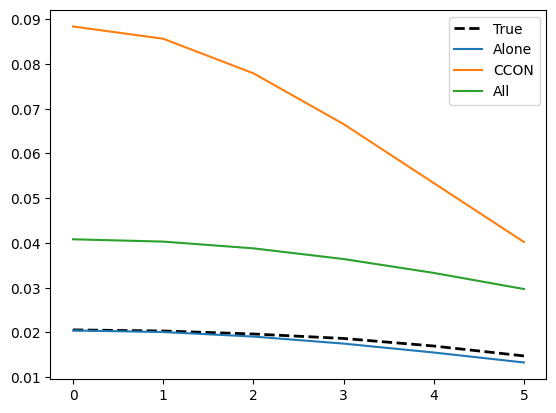

In [34]:
for i in range(1):
    plt.plot(true_densities[i], label="True", linestyle="--", color="black", linewidth=2)
    plt.plot(estimated_densities_alone[i], label="Alone")
    plt.plot(estimated_densities_CCON[i], label="CCON")
    plt.plot(estimated_densities_all[i], label="All")
    plt.legend()
    plt.show()

In [82]:
X_tilde_unique = np.unique(X_tilde, axis=0) 
regression_line_alone = (X_tilde_unique @ webs[atom].betas_WEB[residue].T).T
regression_line_CCON = (X_tilde_unique @ web_CCON.betas_WEB[residue][np.where(web_CCON.atoms_order[residue] == atom)].T).T
regression_line_all = (X_tilde_unique @ web_all.betas_WEB[residue][np.where(web_CCON.atoms_order[residue] == atom)].T).T

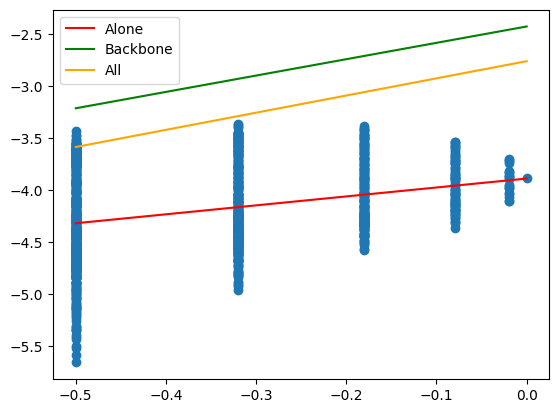

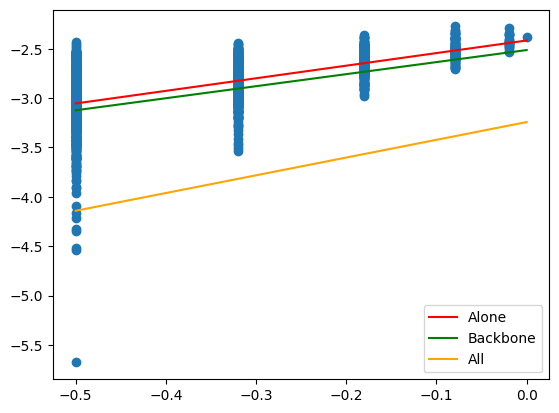

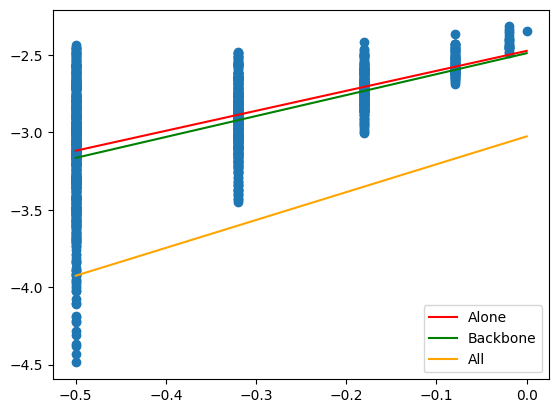

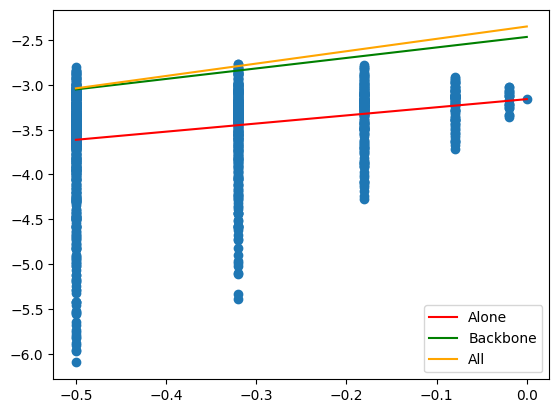

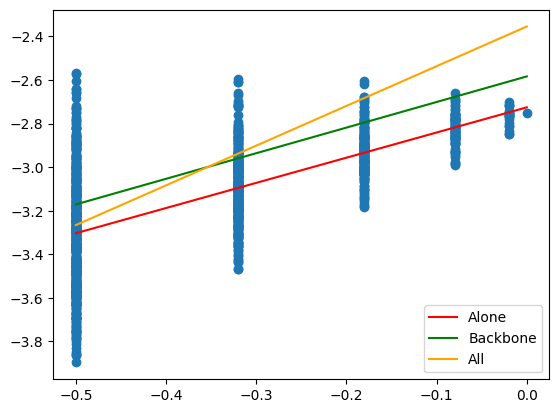

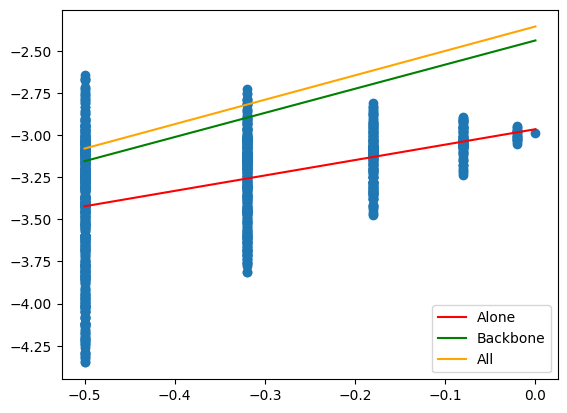

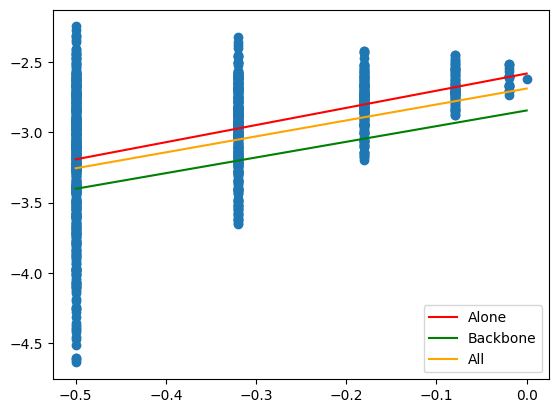

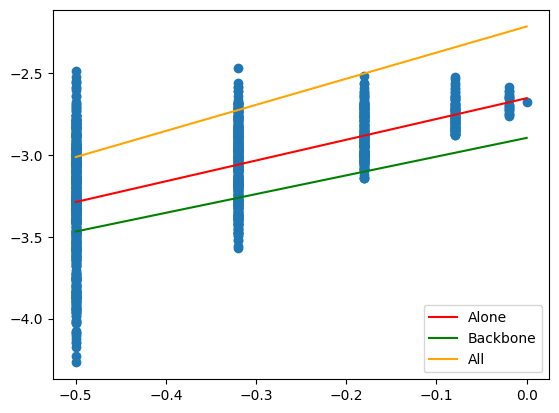

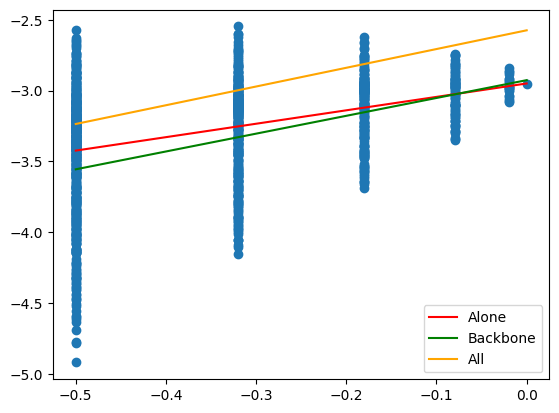

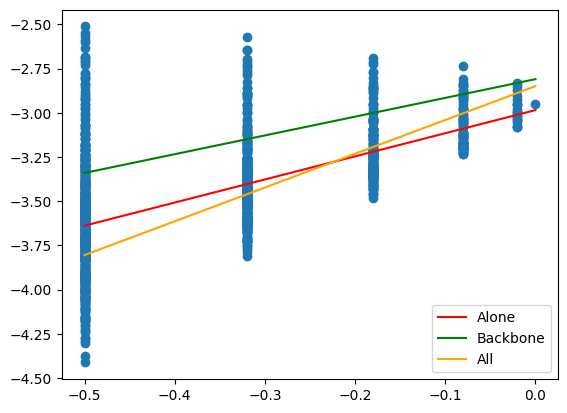

In [89]:
for i in range(10):
    plt.scatter(X_tilde[:, 1], webs[atom].data_log[residue][i])
    plt.plot(X_tilde_unique[:, 1], regression_line_alone[i], color="red", label="Alone")
    plt.plot(X_tilde_unique[:, 1], regression_line_CCON[i], color="green", label="Backbone")
    plt.plot(X_tilde_unique[:, 1], regression_line_all[i], color="orange", label="All")
    plt.legend()
    plt.show()